# Análise do Problema

## Objetivo

  - Desenvolver um modelo de previsão de preços a partir do dataset oferecido e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema.

## Análise Exploratória
  - Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
  - O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
  - Existe algum padrão no texto do nome do local para lugares de mais alto valor?
  
## Modelo
### Feature Selection e Feature Engineering
- Quais variáveis foram usadas e quais transformações?
### Tipos de Modelos
   - Se trata de um modelo de Regressão ou Classificação?
   - Qual modelo mais se adequa?
   - Qual Métrica de Performance foi a escolhida e por que?
### Fazendo Previsões  - Supondo um apartamento com x características, qual seria o preço?
### Guardando o Modelo
   - Salvar o modelo em ".pkl"
### Entrega de Vídeo explicativo, Jupyter Notebook e Modelo .pkl e ReadMe com Requirements

### Práticas de Programação / Documentação do Código 
  - Para cada função , explicar o que ela faz, Parâmetros e Retorno da função
  - snake_case, nomenclatura de variáveis
  - Modularização
  - Comentários em português, variáveis em inglês
## ----------------------------------------------------------------------------------


## --------------------------------------------------------------------------------
# Passo a Passo - Análise Exploratória

 - Análise de Valores Faltantes 
 - Análise de Outliers de "Preço" : Box Plots, IQR e Yeo-Johson Transformation
### Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?
- Fazer Média de Preços("price") por "minimo_noites", "room_type", "bairro",  "bairro_group" e plots(gráfico de barras horizontais)/tabelas.
- Fazer Mapas (Heat Map e Colorful Map) com parâmetro "price", ver locais de mais intensidade de preço
### O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?
- Mapa de Dispersão de Variáveis (Scatter Plots) e Histogramas
- Testes de Normalidade para checar normalidade das variáveis
- Dado o Teste de Normalidade, aplicar Teste de Correlação de Variáveis, para ver quais interferem mais no preço

### Existe algum padrão no texto do nome do local para lugares de mais alto valor?
- Usar um mapa de palavras para ver as palavras mais comuns

## --------------------------------------------------------------------------------

# Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import joblib

## Bibliotecas para Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
## Bibliotecas para Mapas
import folium 
from folium.plugins import HeatMap
import branca.colormap as cm
## Bibliotecas para Testes Estatísticos
import scipy.stats
from statsmodels.stats.diagnostic import lilliefors
from scipy import stats
### Bibliotecas para WordCloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

## Bibliotecas para Modelos
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor



# Lendo e Visualizando o Conjunto de Dados

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("./data/teste_indicium_precificacao.csv")

In [4]:
data.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

# Análise de Valores Faltantes

In [5]:
## Nome e Host_name não são variáveis tão relevantes para o modelo ou para a análise
## Além disso, possuem um valor muito pequeno de valores faltantes, podemos apenas ignorá-los
data.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [6]:
## As colunas que não tem ultima_review não tem reviews por mes
data[(data['ultima_review'].isnull()) | (data['reviews_por_mes'].isnull())].shape[0]

10052

In [7]:
## 20,55 % do Dataframe tem esses valores faltantes, o que é muito
## Será considerada uma opção de substituição desses valores posteriormente
100 * (data[(data['ultima_review'].isnull()) | (data['reviews_por_mes'].isnull())].shape[0] / data.shape[0])

20.558759766024462

# Análise de Outliers

- Valores que se distanciam significantemente do conjunto de dados
- Podem afetar a eficiência de transformações como normalização, testes estatísticos e a eficiência de modelos de Machine Learning
- Serão tratados nessa seção

## Box Plots

In [8]:
"""
    Cria Box Plots de cada coluna do Dataframe
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    nrows = número de linhas da grid
    ncols = número de colunas da grid

"""
def create_box_plots(data, nrows, ncols):
    ## Colunas numéricas
    numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
    
    ## Definindo número de linhas e de colunas
    nrows = nrows
    ncols = ncols
    ## Parâmetros de visualização
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15), constrained_layout=True)
    axs = axs.flatten()
    ## Para cada coluna, gera um boxplot considerando todos os dados NÃO NULOS da coluna. Percebe-se isso por data_aux[col].dropna()
    for i, col in enumerate(numeric_cols):
        
        axs[i].boxplot(data[col].dropna())
        axs[i].set_title(f'{col}')
        axs[i].set_ylabel('Valores')
    ## Aqui apaga-se os subplots vazios
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])
    ## Mostra-se os gráficos
    plt.show()

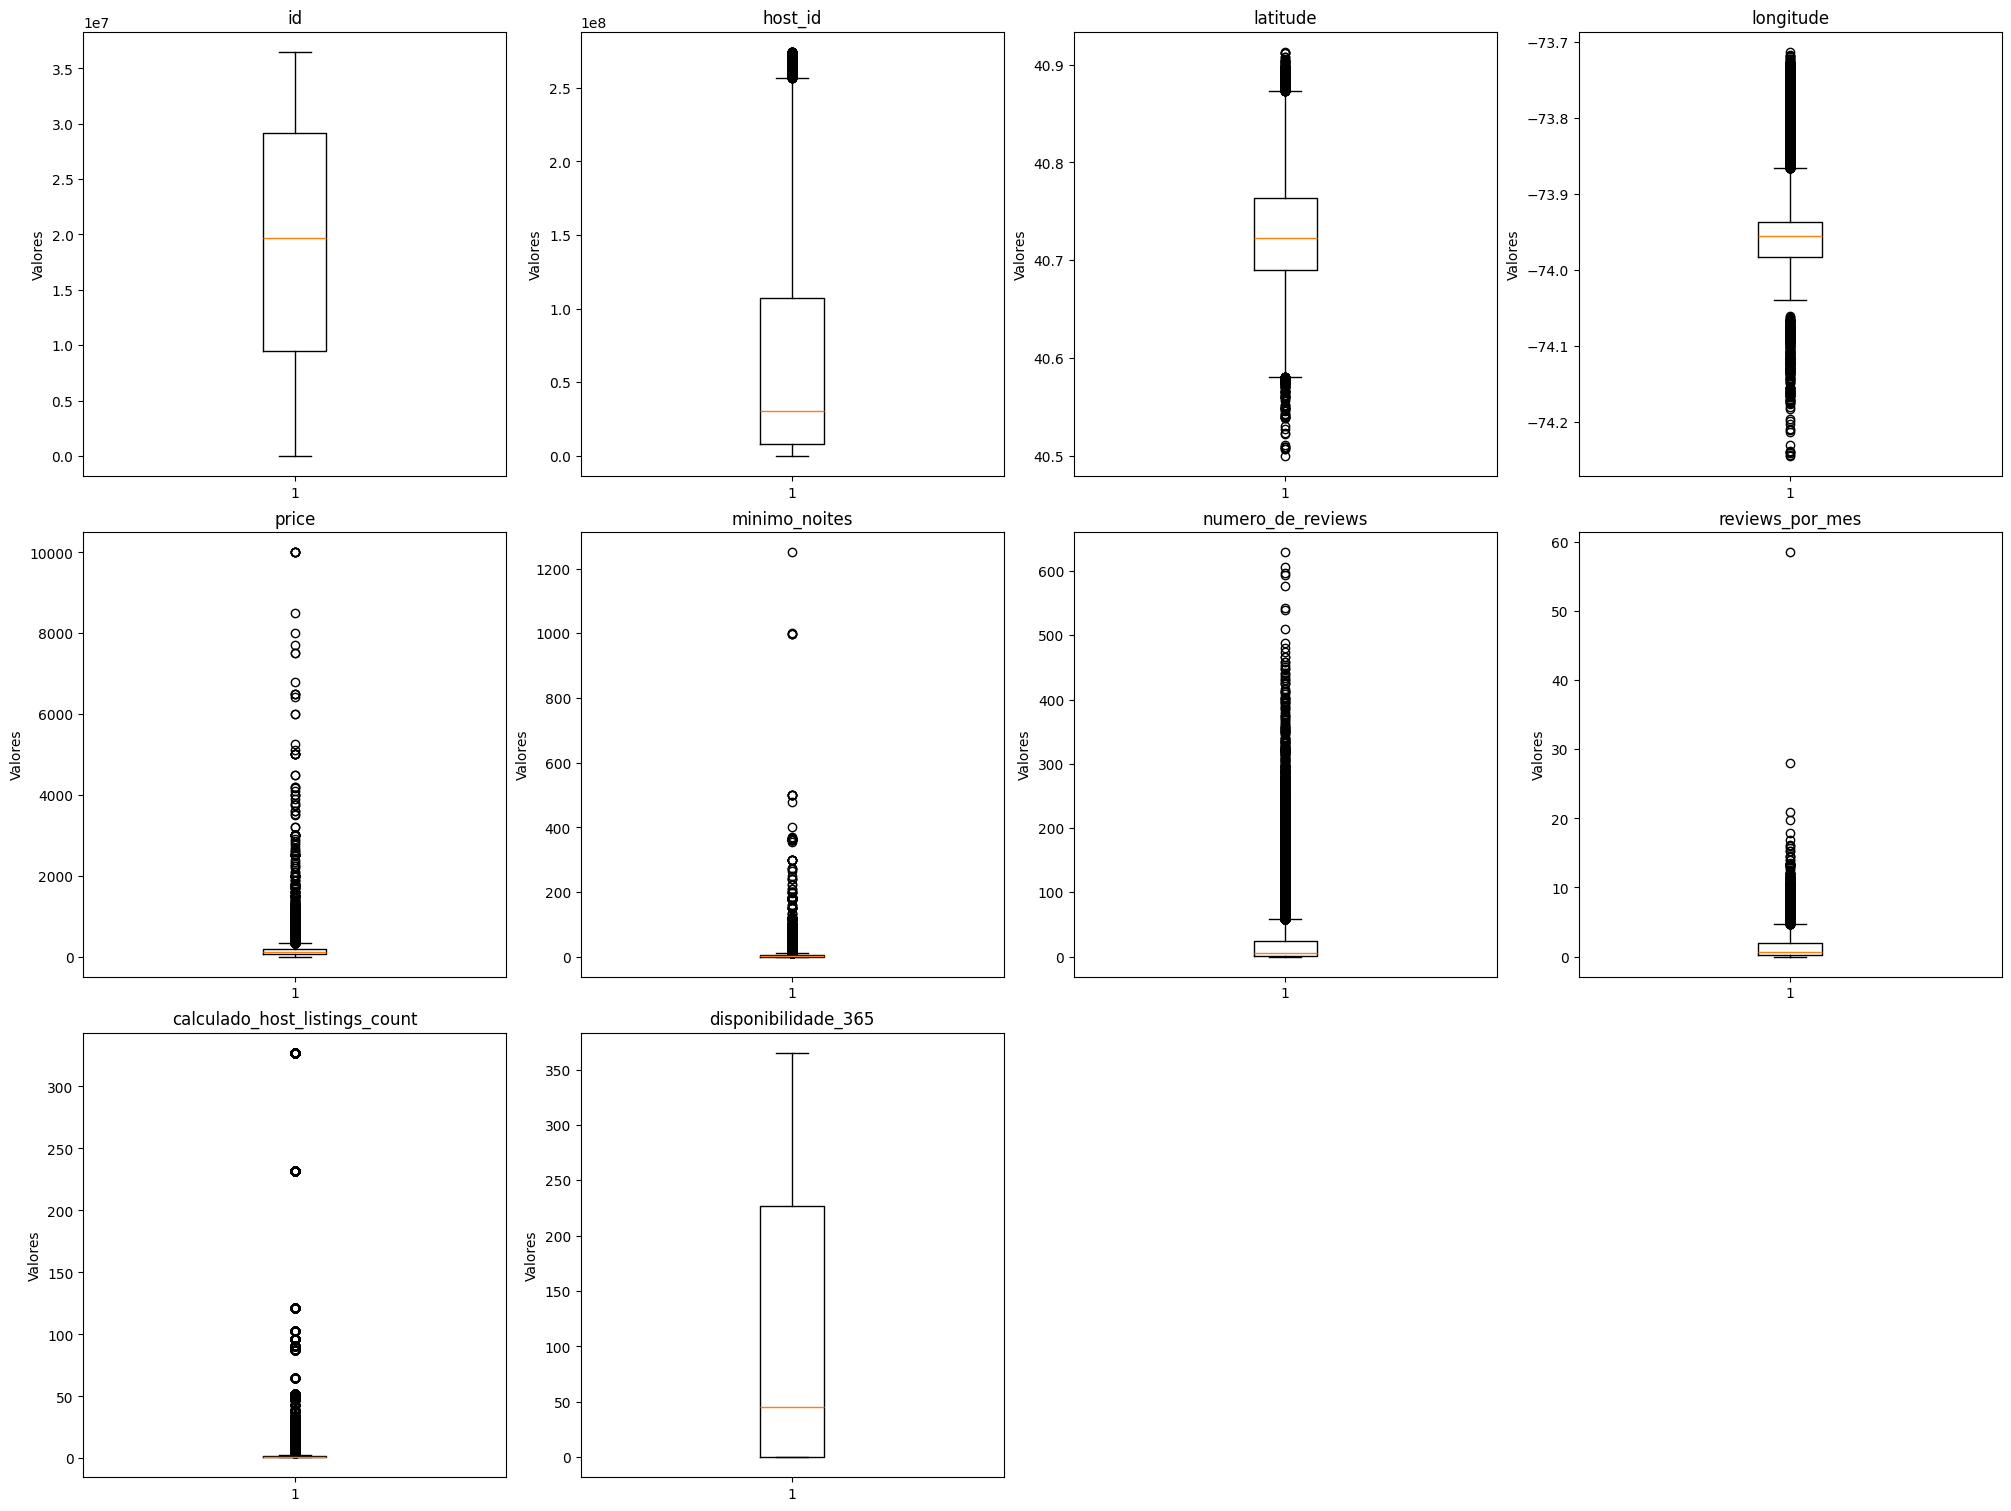

In [9]:
create_box_plots(data, nrows = 3, ncols = 4)

# Estudo dos Outliers com Método IQR

O **método interquartil (IQR - Interquartile Range)** identifica outliers com base nos quartis, especificamente:  
- **1º quartil (Q1 - 25%)**  
- **3º quartil (Q3 - 75%)**  

Ele calcula esses valores e define **limites para outliers**:
- **Limite inferior (lower bound):** `Q1 - 1.5 * IQR`
- **Limite superior (upper bound):** `Q3 + 1.5 * IQR`

Se um valor ultrapassar esses limites, ele é considerado **outlier**.  
O fator **1.5** é o mais comumente utilizado para esss completos**.

In [10]:
"""
    Para cada coluna, deleta os outliers usando o método IQR
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    columns = quais colunas devem ser retirados os outliers (lista)

    Retorno
    conjunto de dados em DataFrame tratado (pandas)
    
"""

def cleaning_data_IQR(data, columns):
    data_cleaned = data.copy()
    for col in columns:
        if col in data.columns and pd.api.types.is_numeric_dtype(data[col]): 
            Q1 = data[col].dropna().quantile(0.25)
            Q3 = data[col].dropna().quantile(0.75)
            IQR = Q3 - Q1
            
            ## Calculando os limites inferiores e superiores
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            ## Filtrando os outliers
            data_cleaned = data_cleaned[(data_cleaned[col] >= lower_bound) & (data_cleaned[col] <= upper_bound)]
            print(f"\nFoi retirado {100 - (data_cleaned.shape[0]/data.shape[0])*100}% do DataFrame, coluna {col}")
    print(f"Foi retirado um total de {100 - (data_cleaned.shape[0]/data.shape[0])*100}% do DataFrame")
    return data_cleaned

### Retirar os outliers não parece uma boa abordagem, dado que teria que retirar uma parcela muito alta do DataFrame


Foi retirado 0.8692273080541497% do DataFrame, coluna latitude

Foi retirado 6.246165173640932% do DataFrame, coluna longitude

Foi retirado 12.16713707203337% do DataFrame, coluna price

Foi retirado 24.546979179449423% do DataFrame, coluna minimo_noites

Foi retirado 35.11064752321347% do DataFrame, coluna numero_de_reviews

Foi retirado 49.451875485744665% do DataFrame, coluna reviews_por_mes

Foi retirado 53.61803084223013% do DataFrame, coluna calculado_host_listings_count

Foi retirado 53.61803084223013% do DataFrame, coluna disponibilidade_365
Foi retirado um total de 53.61803084223013% do DataFrame


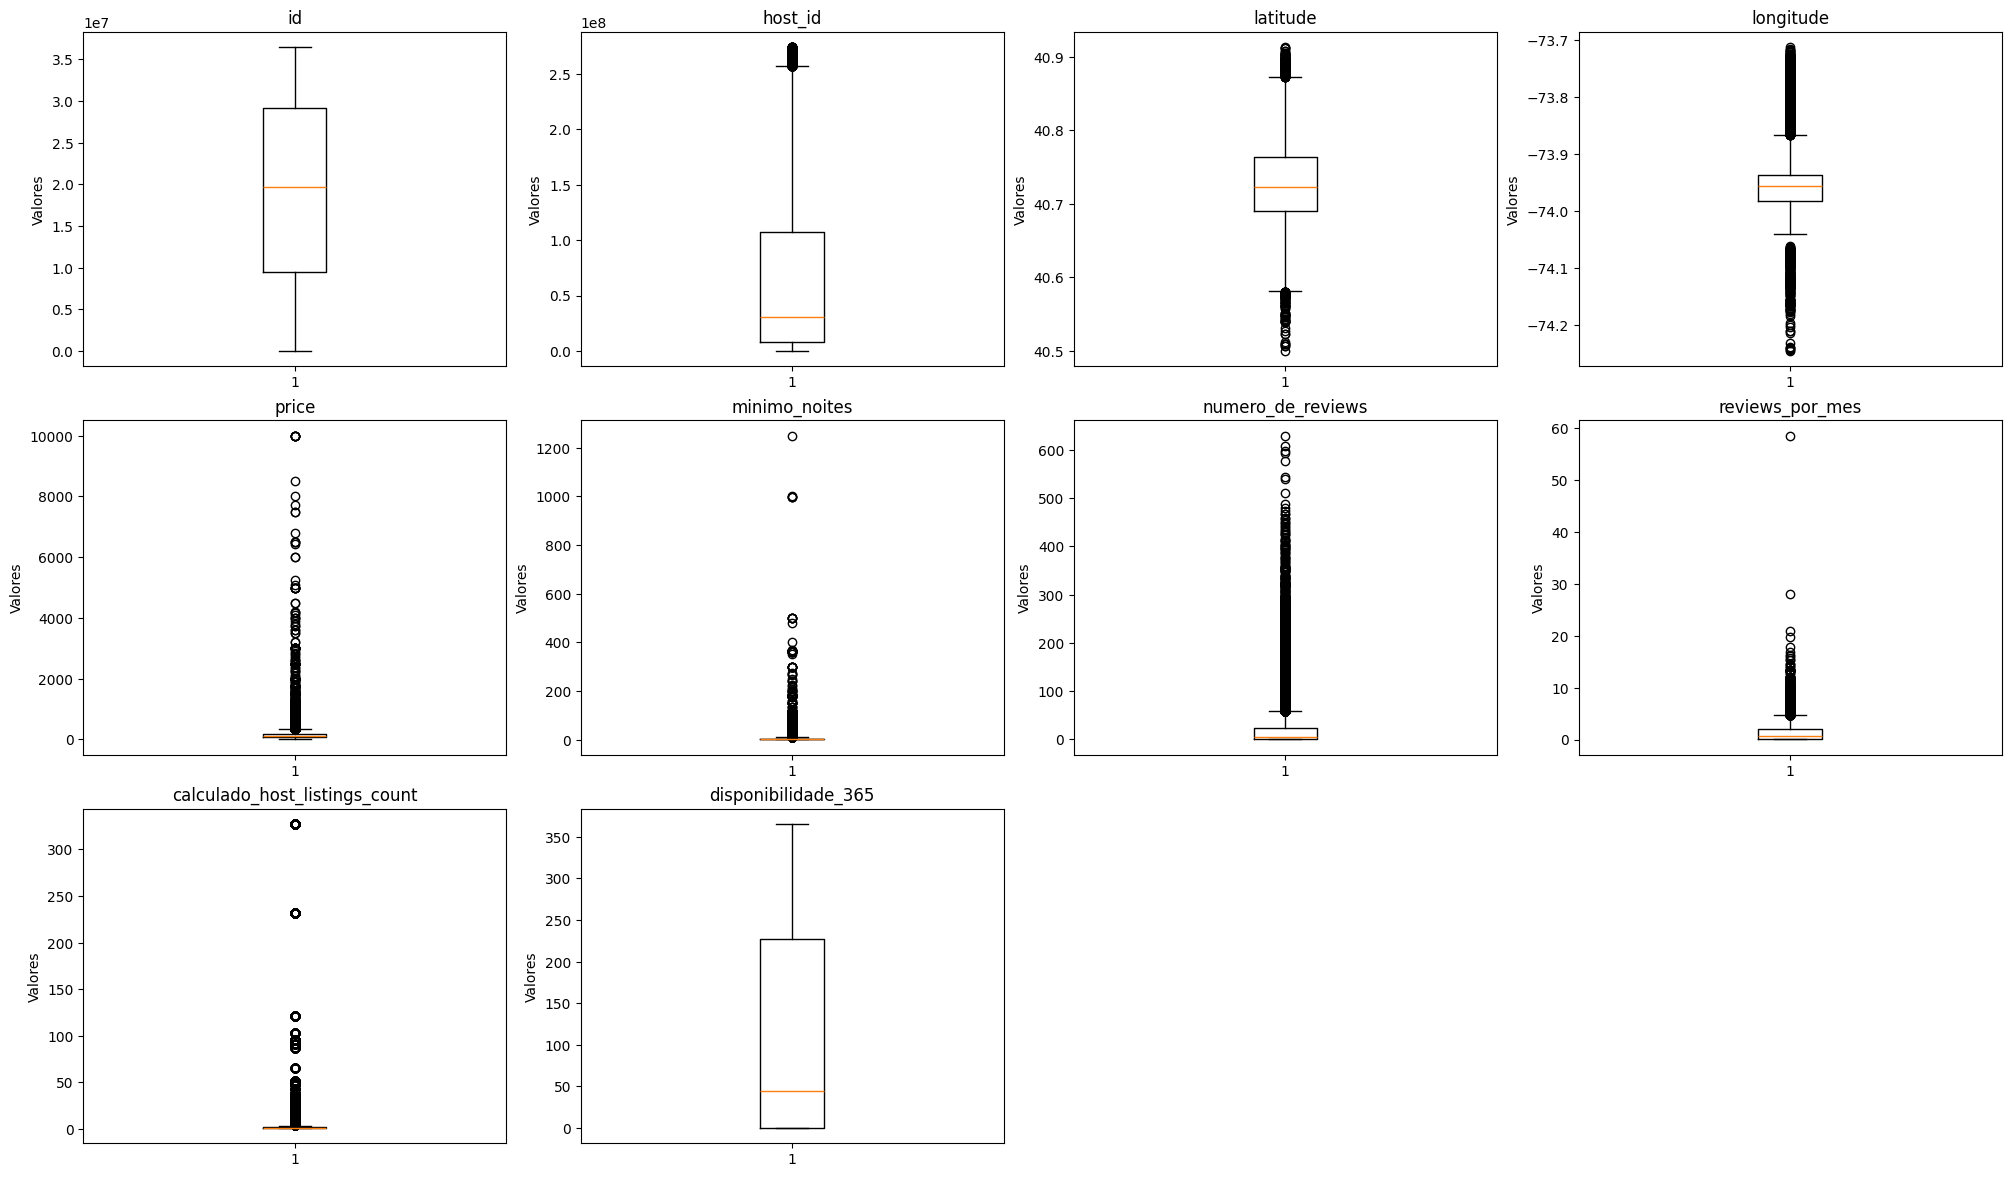

In [11]:
data_cleaned = cleaning_data_IQR(data, ["latitude", "longitude", "price", "minimo_noites", "numero_de_reviews", "reviews_por_mes",
                                 "calculado_host_listings_count", "disponibilidade_365"])
create_box_plots(data, nrows = 4, ncols = 4)

In [12]:
columns = ["latitude", "longitude", "price", "minimo_noites", "numero_de_reviews", "reviews_por_mes",
           "calculado_host_listings_count", "disponibilidade_365"]

## Verificando se há valores negativos em cada coluna
negative_values = (data[columns] <= 0).sum()

## Exibindo resultado
print("quantity de valores negativos por coluna:")
print(negative_values)

quantity de valores negativos por coluna:
latitude                             0
longitude                        48894
price                               11
minimo_noites                        0
numero_de_reviews                10052
reviews_por_mes                      0
calculado_host_listings_count        0
disponibilidade_365              17533
dtype: int64


## Transformação Yeo-Johnson

- A transformação Yeo-Johnson é uma técnica de transformação de dados que visa tornar os dados mais próximos de uma distribuição normal além de reduzir o impacto dos outliers, como a transformação de Box-Cox, mas com a vantagem de funcionar para dados que podem ter valores negativos ou zero.


In [13]:
"""
    Aplicar a transformação Yeo-Johnson nas colunas selecionadas e salvar os modelos para cada coluna,
    em caso de aplicar transformação inversa nos dados.
    
    Parâmetros
    method = método a ser utilizado (yeo-johnson, box-cox, etc.)
    data = conjunto de dados em DataFrame (pandas)
    columns = quais colunas devem ser transformadas (lista)
    save_model = se os modelos serão salvos ou não
    model_filename_prefix = prefixo dos modelos , se salvos
    
    Retorno
    conjunto de dados em DataFrame tratado (pandas)
    
"""

def data_transformation(method, data, columns, save_model=False, model_filename_prefix='power_transformer_model'):
    data_cleaned = data.copy()
    pt = PowerTransformer(method=method)
    
    #@ Aplica o PowerTransformer em cada coluna especificada
    for col in columns:
        data_cleaned[col] = pt.fit_transform(data_cleaned[[col]])
        
        ## Salva o modelo de transformação para cada coluna, se save_model for verdadeiro
        if save_model:
            model_filename = f"modelos_transfomacao_dados/{model_filename_prefix}_{col}.pkl"  
            joblib.dump(pt, model_filename)  
            print(f"Modelo para a coluna '{col}' salvo em {model_filename}")
    
    return data_cleaned


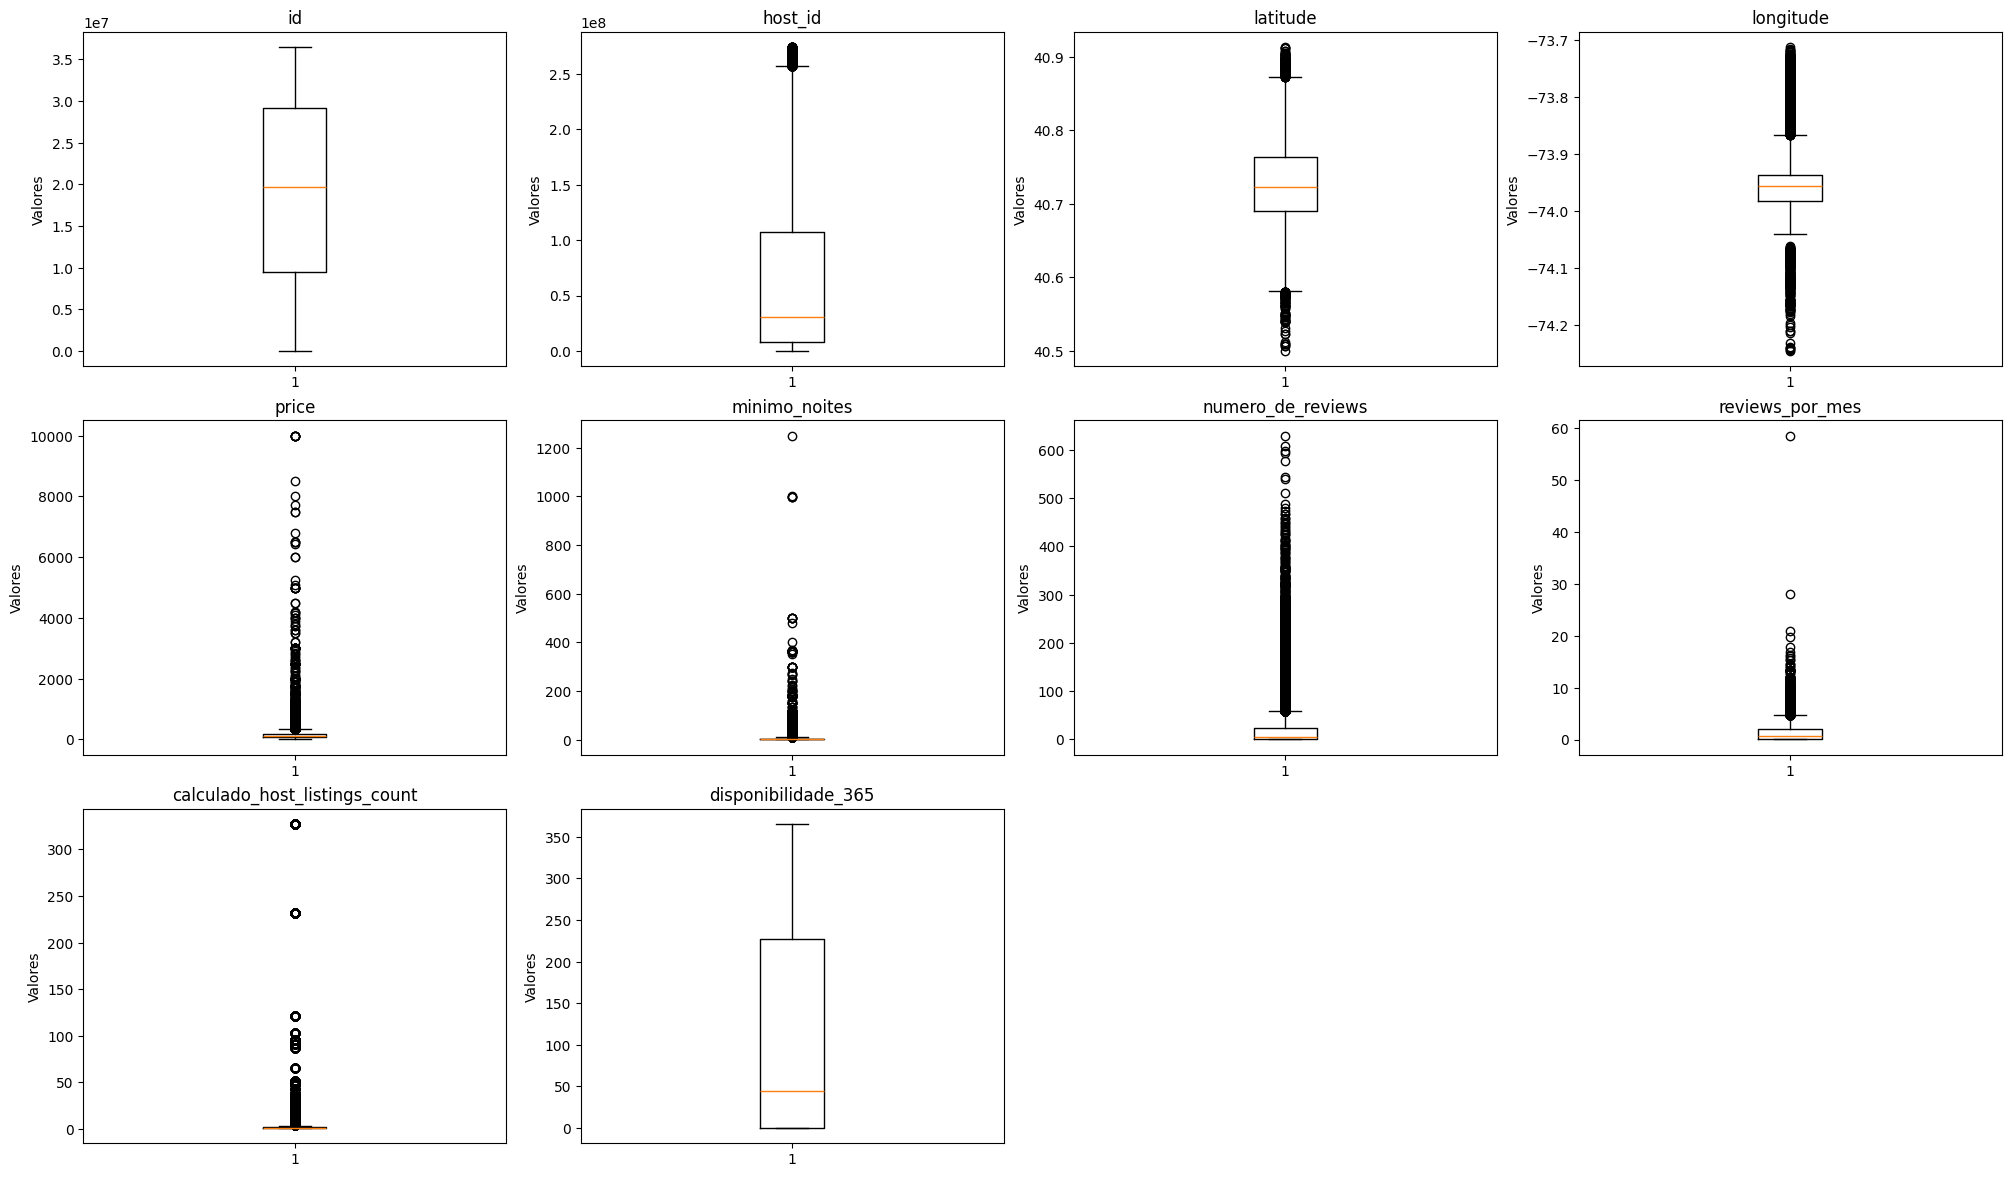

In [14]:
columns = ["price", "minimo_noites", "numero_de_reviews", "reviews_por_mes",
           "calculado_host_listings_count", "disponibilidade_365"]
data_cleaned = data_transformation("yeo-johnson", data, columns)
create_box_plots(data, nrows = 4, ncols = 4)

# Fazer Média de Preços por variáveis distintas do conjunto de dados

In [15]:
"""
    Plotar a média de preços por feature (pode ser bairro, bairro_group, etc.)
    
    Parâmetros
    consider_outliers = se outliers serão considerados na análise. Se não forem, aplica-se método IQR
        OBS: o objetivo desse campo é que os outliers não impactem tanto na interpretação da média
    data = conjunto de dados em DataFrame (pandas)
    columnn_name = qual feature será comparada
    ascending = se queremos ver as maiores ou menores médias. Ascending = True significa ver as menores.
    quantity = quantidade de dados / médias que queremos ver
    
    Retorno
    conjunto de dados em DataFrame tratado (pandas) contando a média de preço por feature
    
"""

def plot_mean_prices(data, consider_outliers, column_name, ascending, quantity):
    if not consider_outliers:
        data_cleaned = cleaning_data_IQR(data, [column_name, "price"])
    else:
        data_cleaned = data.copy()
    ## Exemplo de gráfico de barras horizontais para visualizar as médias de preço por 'minimo_noites'
    mean_prices = data_cleaned.groupby([column_name])["price"].mean().reset_index()
    mean_prices = mean_prices.sort_values(by="price", ascending=ascending)
    mean_prices = mean_prices.iloc[:quantity]
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=mean_prices, 
        y=column_name, 
        x="price", 
        palette="magma", 
        orient='h', 
        order=mean_prices[column_name]  ## Garante que o eixo Y siga a ordem dos dados
    )    
    ## Informações gerais do gráfico
    plt.title(f'Média de Preços por {column_name}')
    plt.xlabel('Preço Médio')
    plt.ylabel(f"{column_name}")
    
    ## Tamanho dos ticks
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()
    return mean_prices


C:\Users\gabia\AppData\Local\Temp\ipykernel_7892\1761298216.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


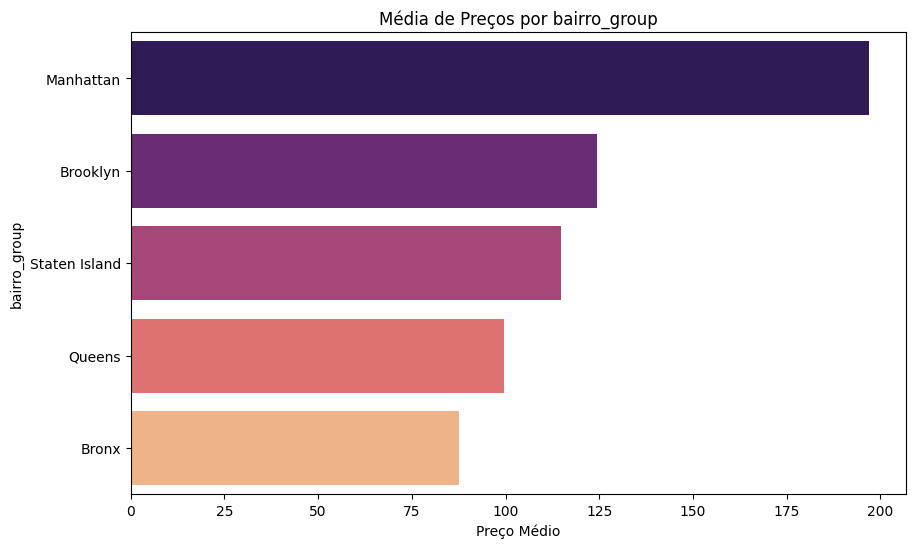

In [16]:
# columns = ["price", "minimo_noites", "numero_de_reviews", "reviews_por_mes",
#            "calculado_host_listings_count", "disponibilidade_365"]
mean_prices = plot_mean_prices(data, True, "bairro_group", False, 30)

In [17]:
mean_prices

bairro_group       price
2      Manhattan  196.875814
1       Brooklyn  124.381983
4  Staten Island  114.812332
3         Queens   99.517649
0          Bronx   87.496792

## Heat Map e Colorful Map com parâmetro "price"


In [18]:
"""
    Plota CircleMarkers (pontos) de uma cor só em um mapa
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    color = de qual cor serão os pontos
    radius = raio do ponto
    name = noma da coluna para tooltip e popup
    layer = em qual layer (camada) serão adicionados os pontos
    
    Retorno
    Não retorna nada, mas adiciona os pontos ao mapa    
"""
def plot_circlemarkers_one_color(data, color, radius, name, score, layer):
    for _, row in data.iterrows():
        folium.CircleMarker(
                location = [row['latitude'], row['longitude']],
                color = color, 
                radius = radius,
                tooltip = row[name] + " " + str(row[score]), 
                popup = row[name] + " " + str(row[score]), 
                fill = True,
                fill_opacity = 1,
                fill_color = color,
        ).add_to(layer)

"""
    Plota CircleMarkers (pontos) com cores variadas em um mapa, conforme um colormap.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    radius = raio do ponto
    name = nome da coluna para tooltip e popup
    score = nome da coluna que define a cor do ponto com base no colormap
    layer = em qual layer (camada) serão adicionados os pontos
    colormap = função que mapeia valores de score para cores
    
    Retorno
    Não retorna nada, mas adiciona os pontos ao mapa    
"""
def plot_circlemarkers_multi_color(data, radius, name, score, layer, colormap):
    for _, row in data.iterrows():
        folium.CircleMarker(
                location = [row['latitude'], row['longitude']],
                color = colormap(row[score]), 
                radius = radius,
                tooltip = str(row[name]) + " " + str(row[score]), 
                popup =  str(row[name]) + " " + str(row[score]), 
                fill = True,
                fill_opacity = 1,
                fill_color = colormap(row[score]),
        ).add_to(layer)

"""
    Plota CircleMarkers para outliers inferiores, outliers superiores e não outliers em um mapa, 
    utilizando diferentes cores e camadas para cada grupo.
    
    Parâmetros
    out_lower = conjunto de dados de outliers inferiores (DataFrame pandas)
    out_upper = conjunto de dados de outliers superiores (DataFrame pandas)
    non_outliers = conjunto de dados de não outliers (DataFrame pandas)
    color_lower = cor dos pontos para outliers inferiores
    color_upper = cor dos pontos para outliers superiores
    radius = raio dos pontos
    name = nome da coluna para tooltip e popup
    score = nome da coluna que define o valor a ser exibido no tooltip e popup
    layer_non = camada onde os pontos não outliers serão adicionados
    layer_upper = camada onde os pontos de outliers superiores serão adicionados
    layer_lower = camada onde os pontos de outliers inferiores serão adicionados
    colormap = função que mapeia valores de score para cores, utilizada para os não outliers
    
    Retorno
    Não retorna nada, mas adiciona os pontos ao mapa em diferentes camadas.    
"""
def plot_circlemarkers_outliers(out_lower, out_upper, non_outliers, color_lower, color_upper, radius, 
                                name, score, layer_non, layer_upper, layer_lower, colormap):
    plot_circlemarkers_one_color(out_lower, color_lower, radius, name, score, layer_lower)
    plot_circlemarkers_one_color(out_upper, color_upper, radius, name, score, layer_upper)
    plot_circlemarkers_multi_color(non_outliers, radius, name, score, layer_non, colormap)
    

In [19]:

"""
    Identifica outliers com base no método IQR (Intervalo Interquartil) para uma coluna específica de um DataFrame.
    
    Parâmetros
    df = conjunto de dados em DataFrame (pandas)
    column = nome da coluna para a qual os outliers serão identificados
    
    Retorno
    outliers_lower = DataFrame contendo os outliers inferiores
    outliers_upper = DataFrame contendo os outliers superiores
    non_outliers = DataFrame contendo os dados que não são outliers
"""
def identificar_outliers(df, column):
    Q1 = df[column].quantile(0.25) 
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerbound = Q1 - 1.5 * IQR
    upperbound = Q3 + 1.5 * IQR

    outliers_lower = df[df[column] < lowerbound]
    outliers_upper = df[df[column] > upperbound]
    non_outliers = df[(df[column] >= lowerbound) & (df[column] <= upperbound)]

    return outliers_lower, outliers_upper, non_outliers


In [20]:
 """
    Plota um mapa de calor (heatmap) com base nos preços de um conjunto de dados.
    
    Parâmetros
    ----------
    data = conjunto de dados em DataFrame (pandas)
    tirar_outliers = indica se os outliers de preços devem ser removidos (True ou False)
    normalization = indica se os preços devem ser normalizados (True ou False)
    quantity = número de pontos a serem considerados para o mapa de calor
    ascending = ordem de classificação dos preços (True para ascendente, False para descendente)
    
    Retorno
    -------
    map = objeto folium.Map contendo o mapa de calor gerado
"""
def price_heatmap(data, tirar_outliers, normalization, quantity, ascending):
    m = folium.Map(location = [data['latitude'].mean(),
                                  data['longitude'].mean() ], zoom_start = 10)
    if tirar_outliers:
        data_aux = cleaning_data_IQR(data, ["price"])
    else:
        data_aux = data.copy()
    if normalization:
        scaler = MinMaxScaler()
        data_aux['price'] = scaler.fit_transform(data_aux[['price']])
    data_aux = data.sort_values(by="price", ascending=ascending)
    data_aux= data_aux.iloc[:quantity]
   ## Transformando data
    heat_data = data_aux[['latitude', 'longitude', 'price']].values.tolist()

    layer_heat_map = folium.FeatureGroup(name = "Heatmap")
    ## Criando Mapa
    HeatMap( heat_data, 
    radius=15,         ## Ponto mais "espalhado"
    blur=15,           ## Desfoque médio
    # max_zoom=10,       ## Zoom máximo onde efeito aparece
    # min_opacity=0.4,   ## Mais visível em áreas de baixa densidade
    # max_val=100,       ## Valor máximo para normalizar intensidades
    # gradient={0.2: 'blue', 0.5: 'lime', 0.8: 'red'}# Gradiente de cores).add_to(layer_heat_map)
    ).add_to(layer_heat_map) 

    layer_heat_map.add_to(m)
    ## Adicionando tipos diferentes de Design ao Mapa
    folium.TileLayer('cartodbpositron', attr='&copy; <a href="https://carto.com/attributions">CartoDB</a>').add_to(m)
    folium.TileLayer('cartodbdark_matter', attr='&copy; <a href="https://carto.com/attributions">CartoDB</a>').add_to(m)
    folium.TileLayer('stamentoner', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)
    folium.TileLayer('stamenterrain', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)
    folium.TileLayer('stamenwatercolor', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)

    folium.LayerControl().add_to(m)
    return m

In [21]:
price_heatmap(data, tirar_outliers = False, normalization =  True, quantity = 50, ascending = True)

In [22]:
"""
    Plota um mapa colorido com base nos preços, exibindo outliers inferiores, superiores e não outliers em diferentes camadas.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    color_out_lower = cor dos pontos para outliers inferiores
    color_out_upper = cor dos pontos para outliers superiores
    radius = raio dos pontos
    quantity = número de pontos a serem considerados para o mapa
    ascending = ordem de classificação dos preços (True para ascendente, False para descendente)
    
    Retorno
    map = objeto folium.Map contendo o mapa colorido gerado
"""

def price_colorful_map(data, color_out_lower, color_out_upper, radius, quantity, ascending):

    m = folium.Map(location = [data['latitude'].mean(),
                                  data['longitude'].mean() ], zoom_start = 10)
    data_aux = data.sort_values(by="price", ascending=ascending)
    data_aux= data_aux.iloc[:quantity]
    out_lower, out_upper, non_outliers = identificar_outliers(data_aux, "price")
    scaler = MinMaxScaler()
    colormap = cm.linear.plasma.scale(non_outliers['price'].min(), 
                                      non_outliers['price'].max())
    colormap.add_to(m)
    layer_non_outliers = folium.FeatureGroup(name = "Não Outliers")
    layer_upper_outliers =  folium.FeatureGroup(name = "Outliers Superiores")
    layer_lower_outliers = folium.FeatureGroup(name = "Outliers Inferiores") 

    plot_circlemarkers_outliers(out_lower, out_upper, non_outliers, color_out_lower, color_out_upper, radius, 
                                "bairro", "price", layer_non_outliers, layer_upper_outliers, layer_lower_outliers, colormap)    
   
    layer_non_outliers.add_to(m)
    layer_upper_outliers.add_to(m)
    layer_lower_outliers.add_to(m)

    folium.TileLayer('cartodbpositron', attr='&copy; <a href="https://carto.com/attributions">CartoDB</a>').add_to(m)
    folium.TileLayer('cartodbdark_matter', attr='&copy; <a href="https://carto.com/attributions">CartoDB</a>').add_to(m)
    folium.TileLayer('stamentoner', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)
    folium.TileLayer('stamenterrain', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)
    folium.TileLayer('stamenwatercolor', attr='&copy; <a href="http://stamen.com/">Stamen Design</a>').add_to(m)


    folium.LayerControl().add_to(m)
    return m

In [23]:
price_colorful_map(data = data, color_out_lower = "black", 
                                color_out_upper = "green", 
                                radius = 5, 
                                quantity = 2000, 
                                ascending = True)

## Mapa de Dispersão de Variáveis (Scatter Plots)

In [24]:
"""
    Plota gráficos de dispersão para comparar várias colunas numéricas com o preço.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    drop_outliers = indica se os outliers devem ser removidos (True ou False)
    
    Retorno
    Não retorna nada, mas exibe os gráficos de dispersão.
"""

def scatter_plots(data, drop_outliers):
    ## Seleção de Colunas
    if drop_outliers:
        data_aux = cleaning_data_IQR(data, ["price"])
    else:
        data_aux = data.copy()
    numeric_cols = data_aux.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('price')
    
    ## Parâmetros de visualização
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15), constrained_layout=True)
    axs = axs.flatten()
    
    ## Plotando gráficos de Dispersão com todos os dados não nulos, para cada coluna em comparação a Streams
    for i, col in enumerate(numeric_cols):
        axs[i].scatter(data_aux[col].dropna(), data_aux['price'][data_aux[col].notnull()], alpha=0.5)
        axs[i].set_title(f'{col} vs Price')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Price')
    
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])
    plt.show()

## Scatter Plots


Foi retirado 6.0784554342046135% do DataFrame, coluna price
Foi retirado um total de 6.0784554342046135% do DataFrame


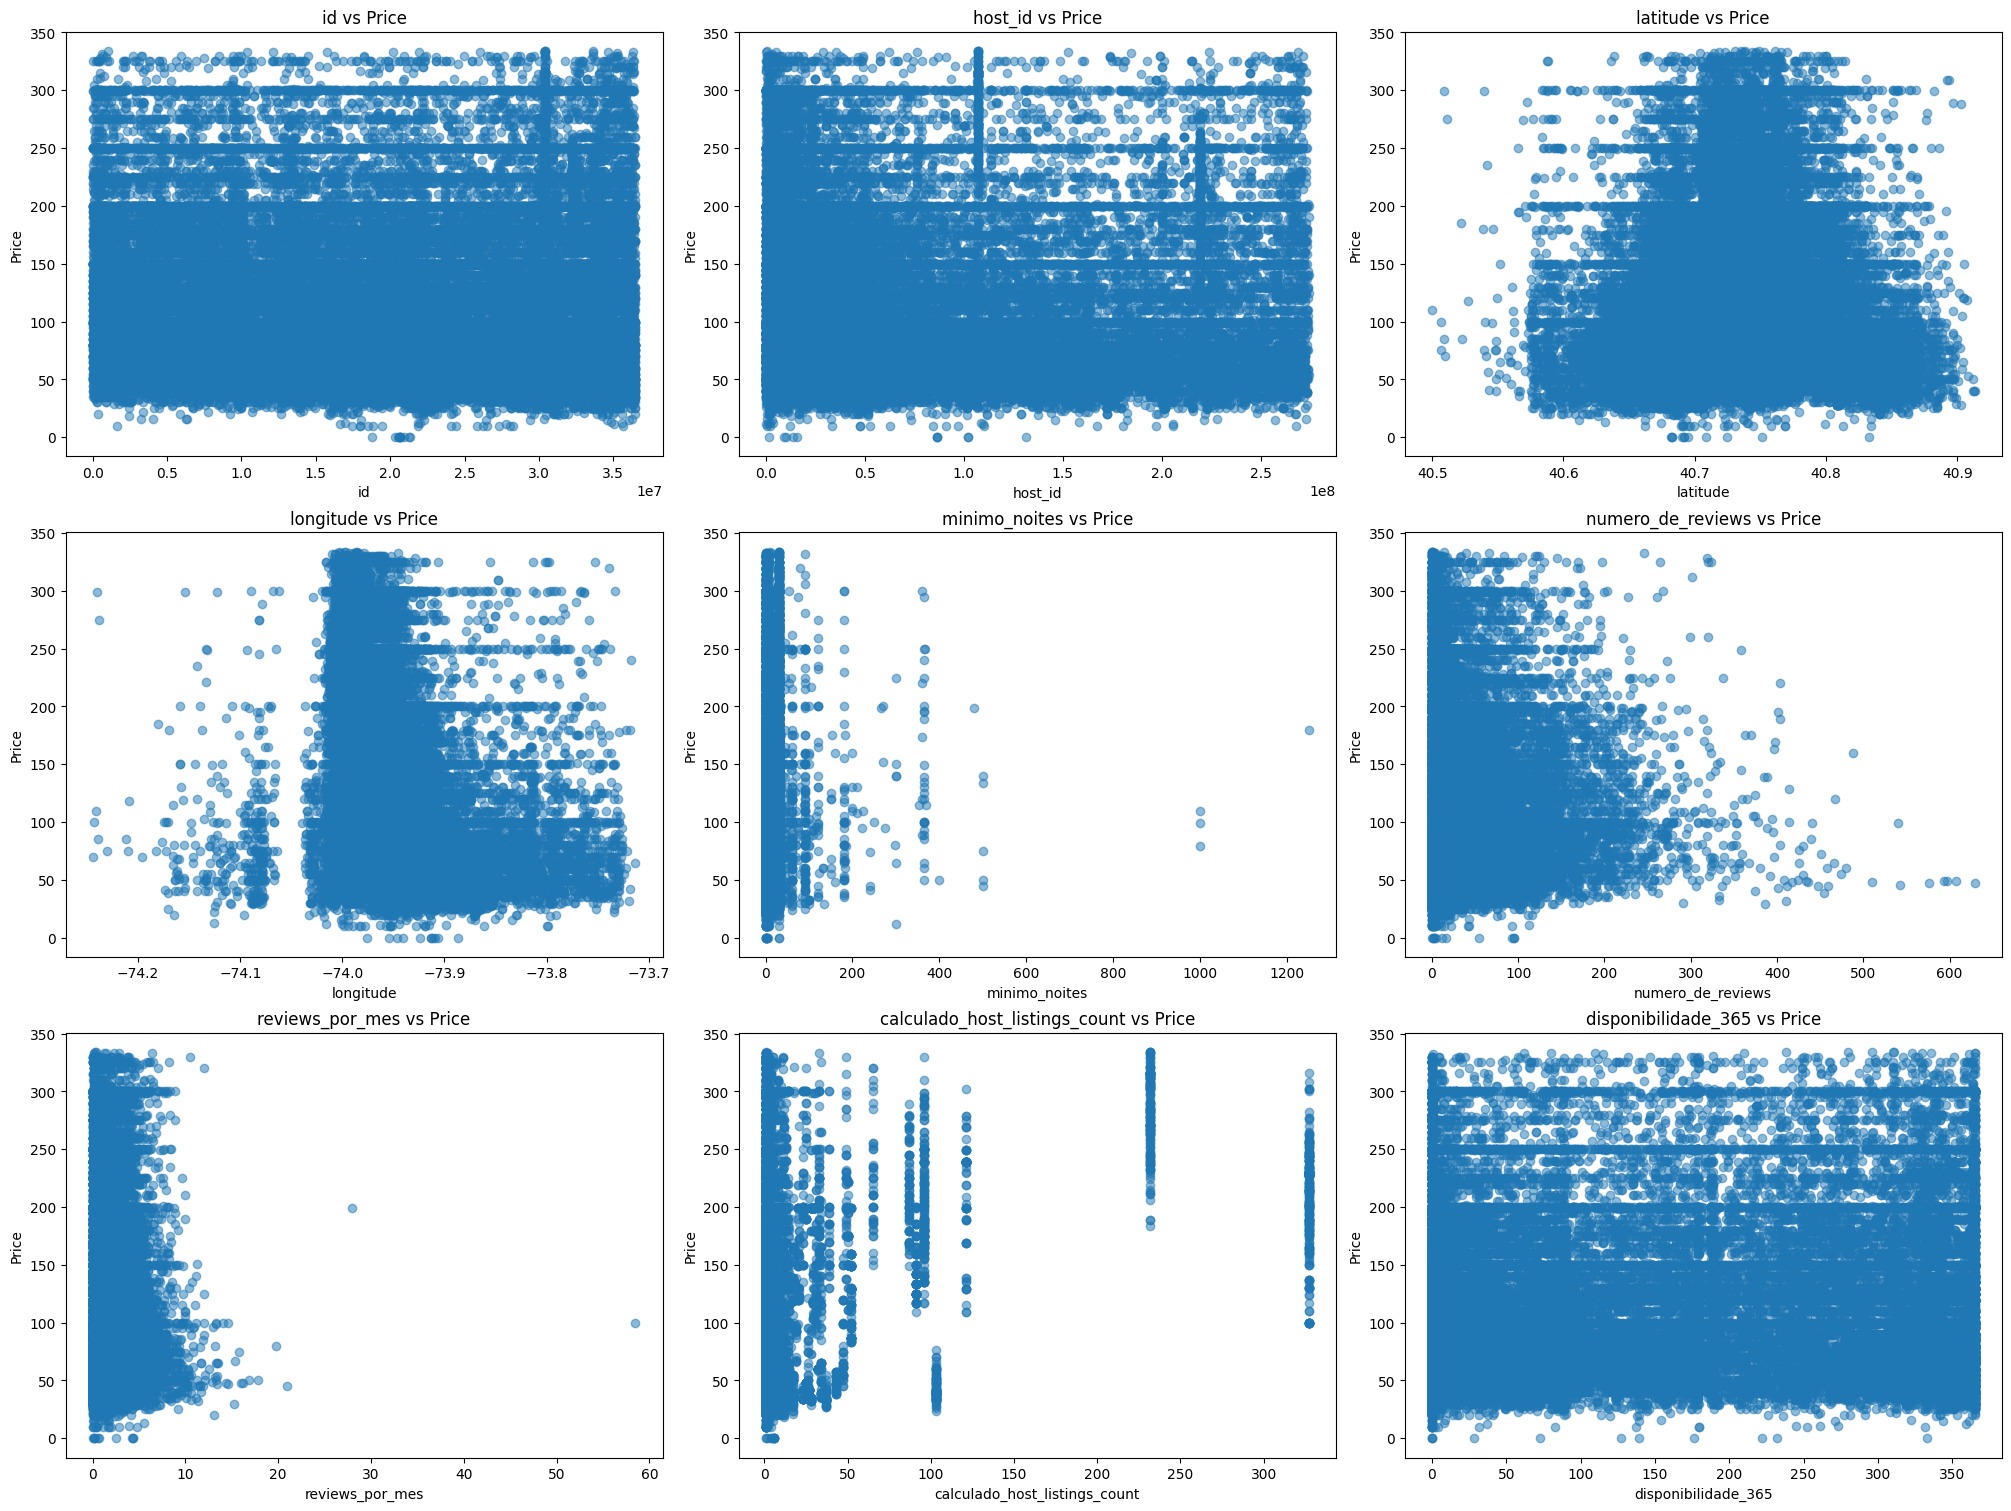

In [25]:
scatter_plots(data, drop_outliers = True)

## Histogramas

In [26]:
 """
    Plota histogramas para várias colunas numéricas com a opção de remover outliers, incluindo uma linha de densidade.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    drop_outliers = indica se os outliers devem ser removidos (True ou False)
    
    Retorno
    Não retorna nada, mas exibe os histogramas com linhas de densidade.
"""
def histograms(data, drop_outliers):
    if drop_outliers:
            data_aux = cleaning_data_IQR(data, ["price"])
    else:
        data_aux = data.copy()
    numeric_cols = data_aux.select_dtypes(include=['number']).columns.tolist()
    if "price" in numeric_cols:
        numeric_cols.remove('price')
    
    ## Parâmetros de visualização
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15), constrained_layout=True)
    axs = axs.flatten()
    
    for i, col in enumerate(numeric_cols):
        ## Considerando apenas valores não ausentes para cada histograma
        if drop_outliers:
            data_aux_outliers = cleaning_data_IQR(data, [col])
        else:
            data_aux_outliers = data_aux.copy()
        axs[i].hist(data_aux_outliers[col].dropna(), bins=30, alpha=0.5, color='blue', label=col, density=True)
    
        ## Linha de densidade
        sns.kdeplot(data_aux_outliers[col].dropna(), ax=axs[i], color='red', lw=2, label='Densidade')
    
        axs[i].set_title(f'{col}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Densidade')
        axs[i].legend()
    
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])
    
    plt.show()


Foi retirado 6.0784554342046135% do DataFrame, coluna price
Foi retirado um total de 6.0784554342046135% do DataFrame

Foi retirado 0.0% do DataFrame, coluna id
Foi retirado um total de 0.0% do DataFrame

Foi retirado 3.1210373460956333% do DataFrame, coluna host_id
Foi retirado um total de 3.1210373460956333% do DataFrame

Foi retirado 0.8692273080541497% do DataFrame, coluna latitude
Foi retirado um total de 0.8692273080541497% do DataFrame

Foi retirado 5.792121732727935% do DataFrame, coluna longitude
Foi retirado um total de 5.792121732727935% do DataFrame

Foi retirado 13.512905468973699% do DataFrame, coluna minimo_noites
Foi retirado um total de 13.512905468973699% do DataFrame

Foi retirado 12.314394404221375% do DataFrame, coluna numero_de_reviews
Foi retirado um total de 12.314394404221375% do DataFrame

Foi retirado 24.225876385650594% do DataFrame, coluna reviews_por_mes
Foi retirado um total de 24.225876385650594% do DataFrame

Foi retirado 14.480304331819866% do DataFra

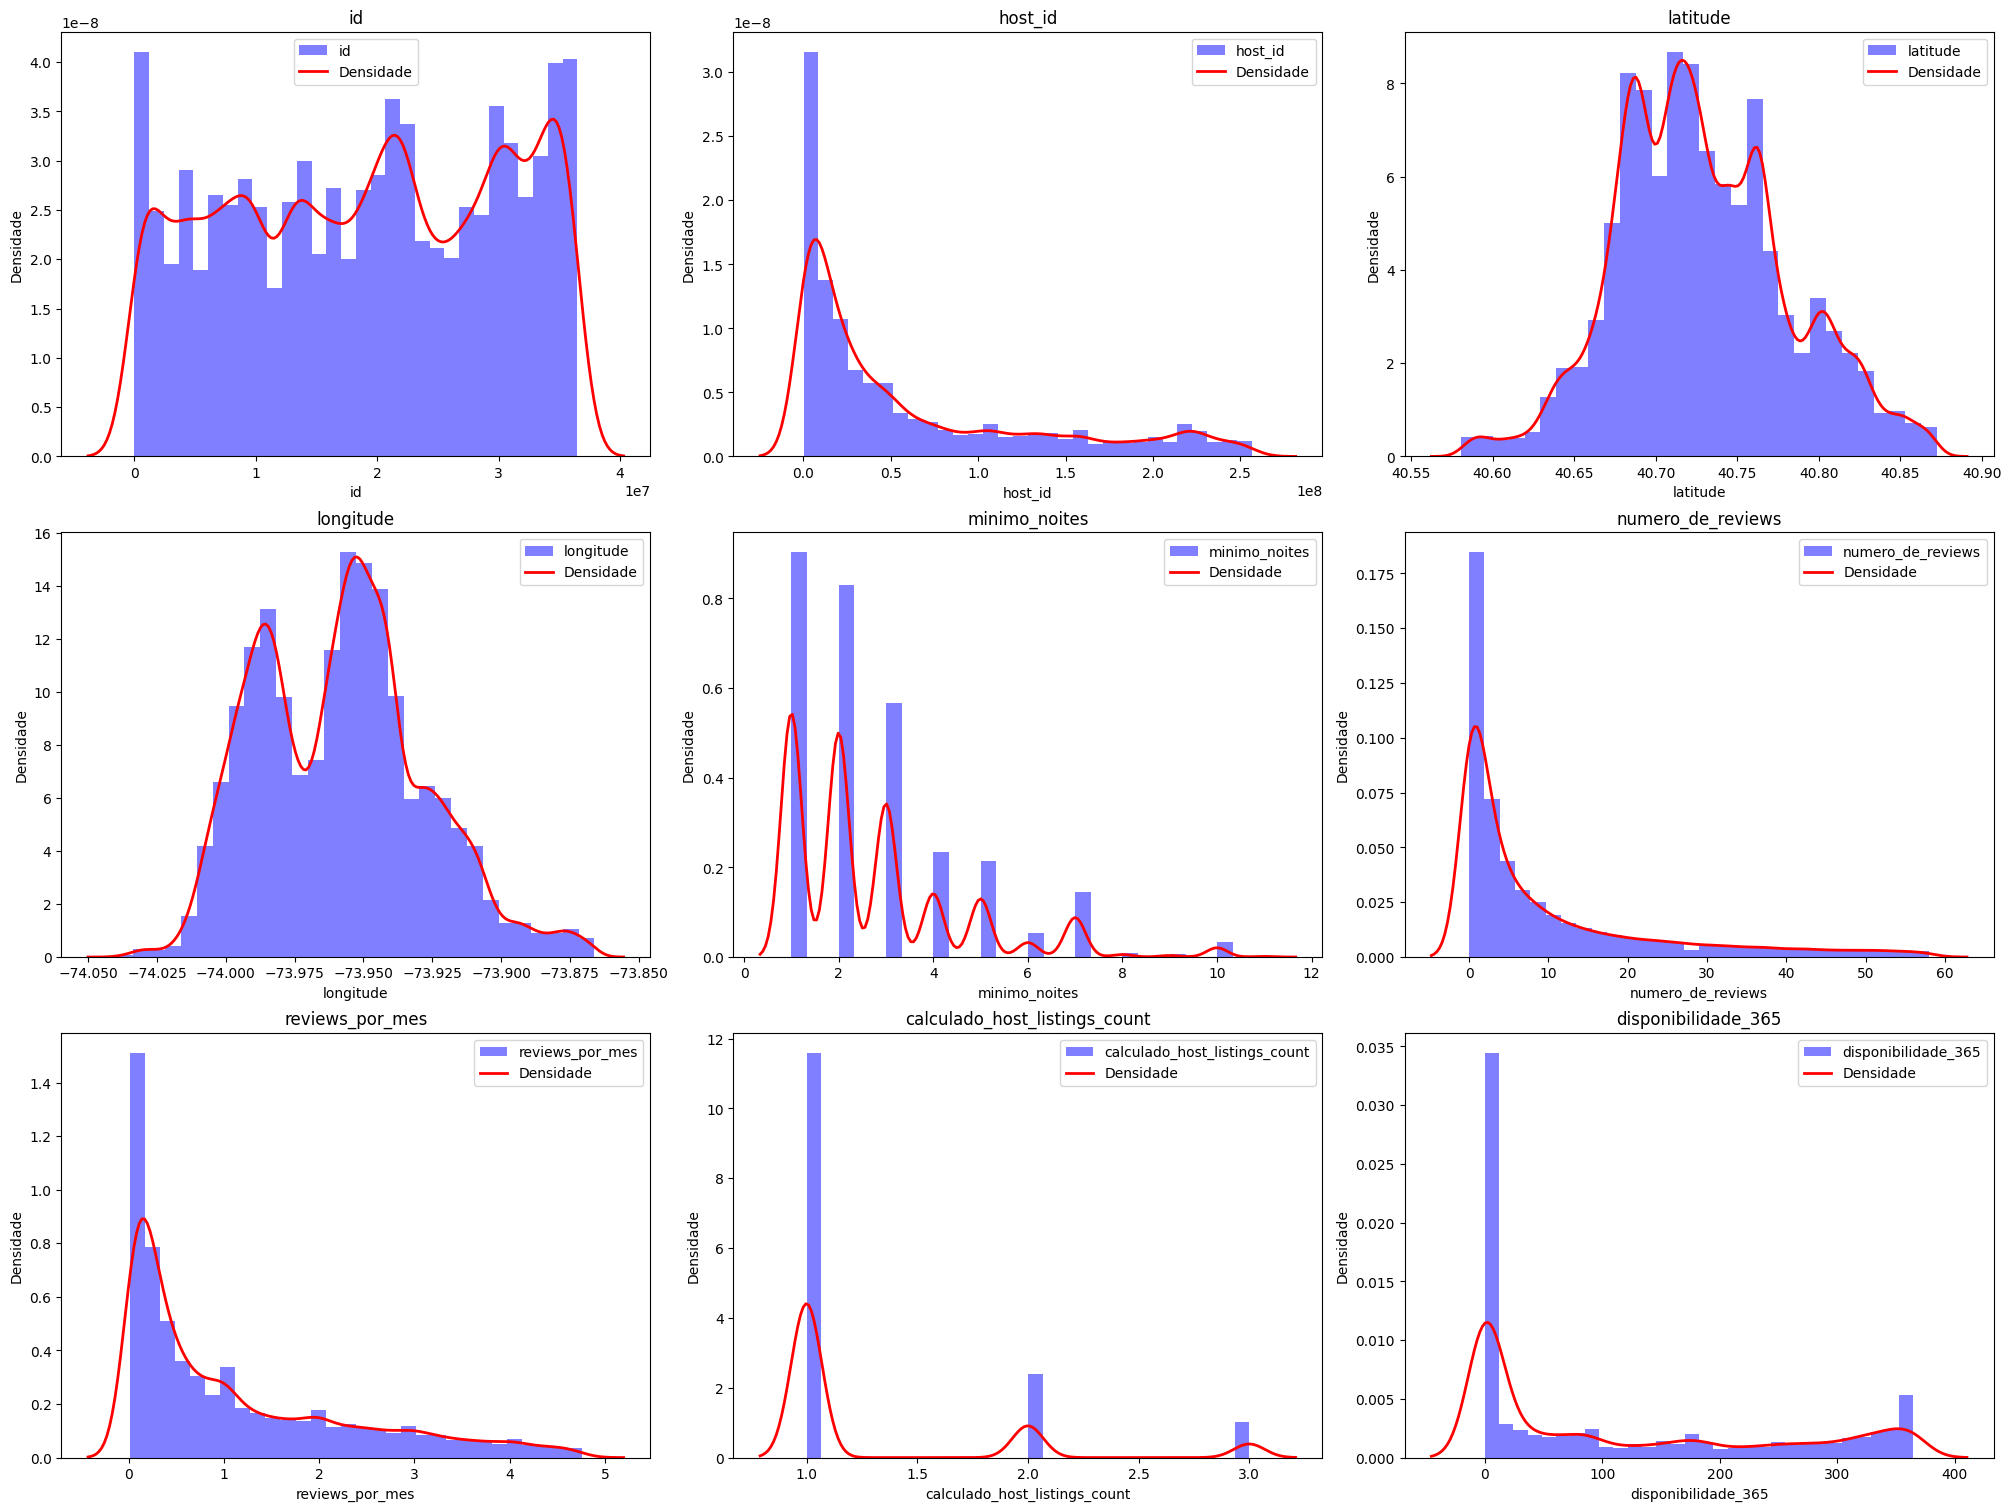

In [27]:
histograms(data, drop_outliers = True)

## Provando que dados não seguem a distribuição normal

### Shapiro-Wilk
 - Ideal para amostras pequenas (50 a 2000)
 - Popular no cálculo de normalidade
 - Baseado na comparação de coeficientes calculdados entre a distribuição da amostra e a distribuição normal teórica

- Hipóteses de teste Shapiro-Wilk
    - Hipótese Nula, H0 (pressuposta inicialmente): distribuição é normal (mais próximo de 1)
    - Hipótese Alternativa , H1 (contrária a H0): distribuição não normal (mais próximos de 0)
- Lembrando, quanto maior o p-value, maior a probabilidade de não rejeição da hipótese nula, ou seja, maior a validação dela

### Kolmogorov-Smirnov (K-S) - com correção de Lilliefors
- Mais geral e sensível ao centro da distribuição. Em geral menos poderoso que AD
- Compara-se a distribuição dos dados com distribuição teórica(você escolhe)
- Teste por si só não é robusto, mas com correção de Lilliefors torna-se mais robusto para amostras de mais de 30 unidades e que contem outliers
- Hipóteses de teste K-S
  - Hipótese Nula, H0 (Pressuposta inicialmente): distribuição é normal (ou escolhida)
  - Hipótese Alternativa, H1 (Contrária a H0): distribuição não normal ( ou diferente da escolhida)
 
### Anderson-Darling
- Mais sensível às caudas da distribuição, preferido quando quer destacar a análise nas caudas
- Compara a aderência de uma amostra a uma distribuição específica (pode ser normal)
- Apresenta melhor desempenho em amostras com mais de 50 unidades
- Hipóteses de teste Anderson-Darling
    - Hipótese Nula, H0 (pressuposta inicialmente): distribuição normal (ou específica)
    - Hipótese Alternativa, H1 (contrária a H0): distribuição não normal (ou não específica)

- Ele retorna os valores críticos (considere que são a probabilidade de validar a hipótese nula, um p-value)
- E retorna os intervalos de significância, como estamos considerando 0.05, escolhe-se o do meio (0.705)

### Jarque-Bera 
- Calcula a normalidade baseado na Skewness e Curtose da amostra
- Compara estimativas teóricas e reais
- Quanto maior a amostra, maior a precisão
- Hipóteses de teste Jarque-Bera
  - Hipótese Nula, H0 (pressuposta inicialmente): distribuição normal
  - Hipótese Alternativa, H1 (contrária a H0): distrbuição não normal
 
### D'Agostino-Pearson
 - Considera Skewness e Curtose
 - Desenvolvido para amostrar mais numerosas, com desempenhos mais robustos para esses casos
 - Hipóteses de teste de D'Agostino-Pearson
   - Hipótese Nula, H0 (pressuposta inicialmente): distribuição normal
   - Hipótese Alternativa, H1 (contrária a H1): distribuição não normal

In [28]:
 """
    Realiza testes de normalidade em colunas numéricas de um DataFrame e retorna os resultados.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    
    Retorno
    normality_df = DataFrame contendo os resultados dos testes de normalidade para cada coluna numérica.

"""
def check_normality(data):
    results = []
    numeric_cols = data.select_dtypes(include=['number']).columns.tolist()
    ## Iterando por cada coluna do DataFrame
    for col in numeric_cols:
        ## Considera apenas valores não nulos
        values = data[col].dropna()
        
        ## Teste Shapiro-Wilk
        stat_shapiro, p_shapiro = stats.shapiro(values)
        is_normal_shapiro = 1 if p_shapiro > 0.05 else 0
        
        ## Teste Anderson-Darling
        stat_ad, crit_values, sig_level = stats.anderson(values)
        is_normal_ad = 1 if stat_ad < crit_values[2] else 0  # Usando o nível de significância de 5%
        
        ## Teste Jarque-Bera
        stat_jb, p_jb = stats.jarque_bera(values)
        is_normal_jb = 1 if p_jb > 0.05 else 0
        
        ## Teste D'Agostino-Pearson
        stat_dp, p_dp = stats.normaltest(values)
        is_normal_dp = 1 if p_dp > 0.05 else 0

        ## Teste Kolmogorov-Smirnov com correção de Lilliefors
        stat_ks, p_ks = lilliefors(values)
        is_normal_ks = 1 if p_ks > 0.05 else 0
        ## Armazenando resultados para cada coluna
        results.append({
            'column': col,
            'shapiro': p_shapiro,
            'shapiro_normal': is_normal_shapiro,
            'anderson_darling': stat_ad,
            'anderson_normal': is_normal_ad,
            'jarque_bera': p_jb,
            'jarque_normal': is_normal_jb,
            'd_agostino_pearson': p_dp,
            'd_agostino_normal': is_normal_dp,
            'kolmogorov_smirnov': p_ks,
            'kolmogorov_normal': is_normal_ks
        })
    
    ## Criando DataFrame com os resultados
    normality_df = pd.DataFrame(results)
    return normality_df



In [29]:
# Testando a normalidade nas colunas do seu DataFrame
normality_results = check_normality(data)

# Exibindo os resultados
normality_results

C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 48894.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 38842.
  res = hypotest_fun_out(*samples, **kwds)


column        shapiro  shapiro_normal  \
0                             id   4.250725e-81               0   
1                        host_id  2.233793e-115               0   
2                       latitude   3.366622e-45               0   
3                      longitude  6.003942e-101               0   
4                          price  1.337006e-151               0   
5                  minimo_noites  8.326132e-155               0   
6              numero_de_reviews  2.592427e-137               0   
7                reviews_por_mes  8.602992e-115               0   
8  calculado_host_listings_count  7.753751e-157               0   
9            disponibilidade_365  9.349539e-116               0   

   anderson_darling  anderson_normal    jarque_bera  jarque_normal  \
0        645.482591                0   0.000000e+00              0   
1       3844.825465                0   0.000000e+00              0   
2        168.048778                0  4.860886e-110              0   
3       1295.284385                0   0.000000e+00              0   
4       7277.305486                0   0.000000e+00              0   
5      10324.062386                0   0.000000e+00              0   
6       7077.522440                0   0.000000e+00              0   
7       2568.007967                0   0.000000e+00              0   
8      15451.657346                0   0.000000e+00              0   
9       4044.535479                0   0.000000e+00              0   

   d_agostino_pearson  d_agostino_normal  kolmogorov_smirnov  \
0        0.000000e+00                  0               0.001   
1        0.000000e+00                  0               0.001   
2       3.811792e-106                  0               0.001   
3        0.000000e+00                  0               0.001   
4        0.000000e+00                  0               0.001   
5        0.000000e+00                  0               0.001   
6        0.000000e+00                  0               0.001   
7        0.000000e+00                  0               0.001   
8        0.000000e+00                  0               0.001   
9        0.000000e+00                  0               0.001   

   kolmogorov_normal  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
6                  0  
7                  0  
8                  0  
9                  0

## Índice de Correlação de Spearman

- A Correlação de Spearman tende a identificar variáveis aleatórias x e y relacionadas mas que não necessariamente crescem linearmanete, mas mudam juntas, em um certo padrão.

- Menos sensível a distribuições não normais
  
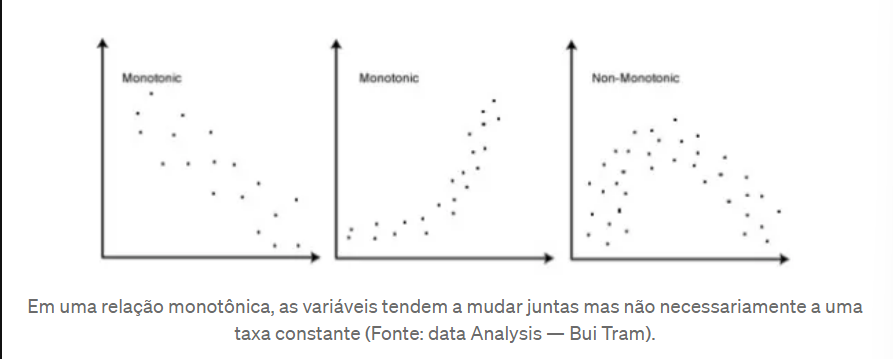

- Por exemplo, se as variáveis aleatórias seguem exatamente y = log(x), o coeficiente de Pearson não será igual a 1, já o coeficiente de Spearman sera 1, pois reflete uma relação não linear.


In [30]:
 """
    Plota uma matriz de correlação entre as variáveis numéricas de um DataFrame, com base no método escolhido.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    method = método de correlação a ser utilizado (ex: 'pearson', 'kendall', 'spearman')
    quantity = número de amostras a serem consideradas
    ascending = define a ordem crescente ou decrescente para o critério 'price'
    
    Retorno
    Não retorna nada, mas exibe a matriz de correlação como um gráfico.
"""
def correlation_matrix(data, method, quantity, ascending):
    results = []
    data_aux = data.select_dtypes(include=['number'])
    
    data_aux = data_aux.sort_values(by="price", ascending=ascending)
    data_aux= data_aux.iloc[:quantity]
    ## Criação de matriz de correlação com método escolhido
    correlation_matrix = data_aux.corr(method = method)

    plt.figure(figsize=(12, 10))
    ## Plotando matriz
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, annot_kws={"size": 8} )
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

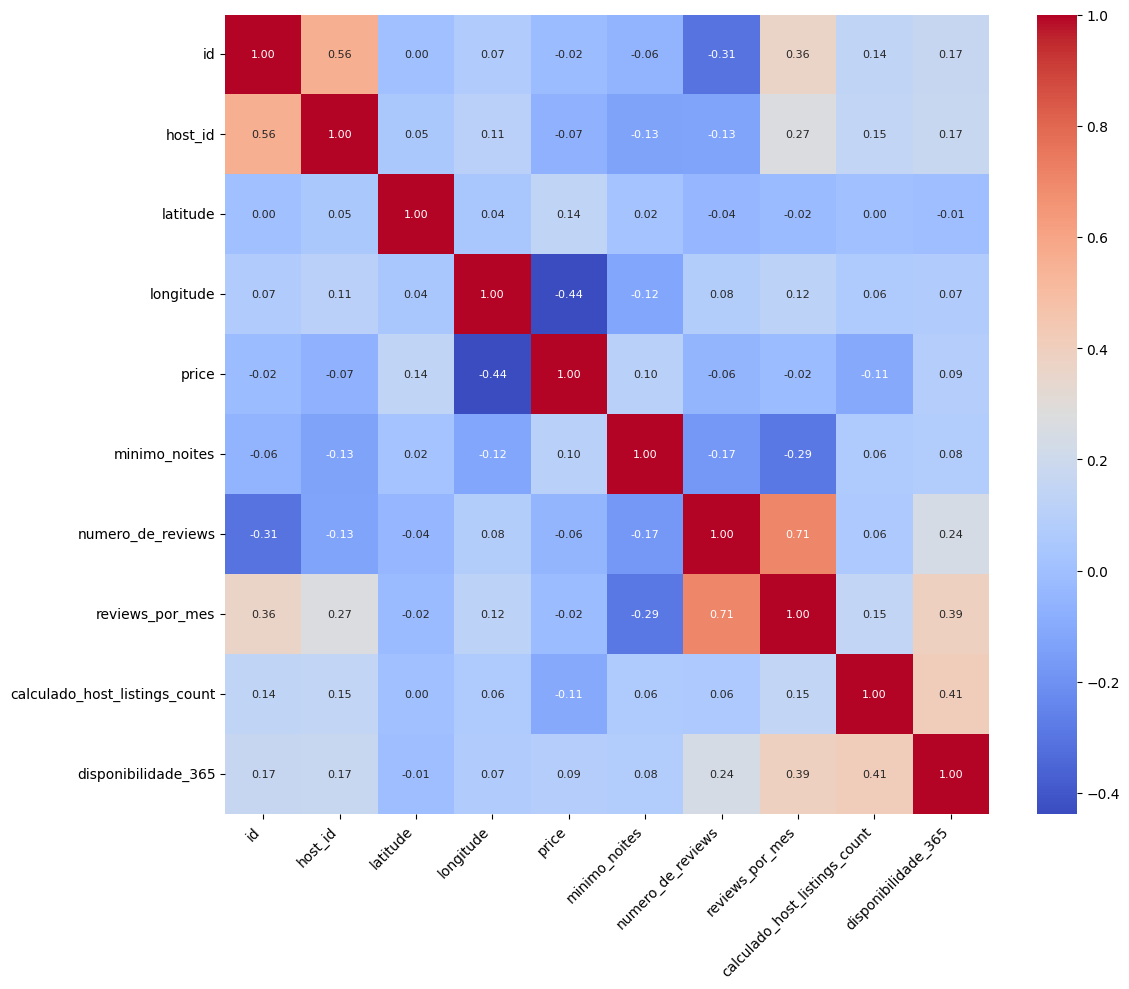

In [31]:
correlation_matrix(data, "spearman", quantity = int(data.shape[0]),  ascending = True)

## Word Cloud
- Usar um mapa de palavras para ver as palavras mais comuns (filtra-se primeiro os 10%, 5% de maior valor, depois aplica-se)


In [32]:
## Baixando Stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gabia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
"""
    Gera uma Word Cloud com base nos valores de uma coluna do DataFrame.
    
    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    column = nome da coluna a ser utilizada para gerar a Word Cloud
    quantity = número de amostras a serem consideradas
    ascending = define a ordem crescente ou decrescente para o critério 'price'
    
    Retorno
    Não retorna nada, mas exibe a Word Cloud como uma imagem.
"""
def word_cloud(data, column, quantity, ascending):
    ## Selecionando apenas a quantidade a ser analisada do DataFrame
    data_aux = data.sort_values(by="price", ascending=ascending)
    data_aux= data_aux.iloc[:quantity]
    
    all_names = ' '.join(data_aux[column].dropna())  # Juntar letras, ignorando NaN

    stopwords_nltk = set(stopwords.words('english'))

    ## Criando do word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords = stopwords_nltk).generate(all_names)

    ## Plotando word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') 
    plt.title('Word Cloud das Letras dos Anúncios', fontsize=20)
    plt.show()

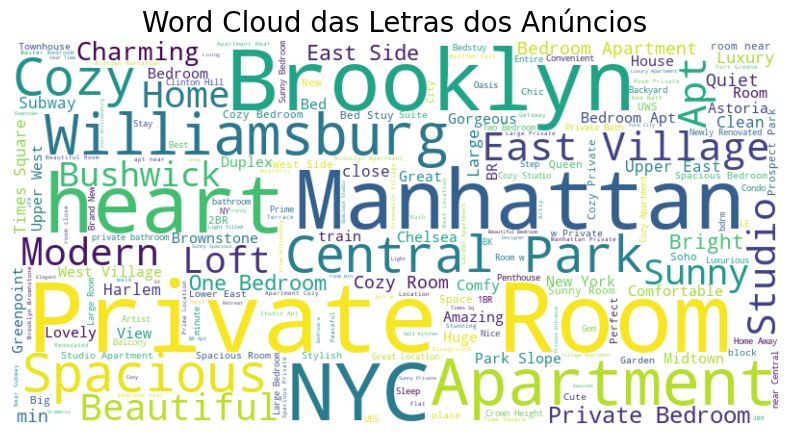

In [34]:
word_cloud(data, "nome", quantity = int(data.shape[0] * 1), ascending = False)

## --------------------------------------------------------------------------------
# Passo a Passo Modelo

## Feature Selection e Feature Engineering
 - Ver quais features são inúteis e descartá-las
 - Verificação de valores nulos (pensar se vai substituir pela média, mediana etc ou se vai retirar para modelo)
 - Categorização de Variáveis por Encoders (Label Encoder, One-hot Encoder)

## Seleção de Modelos de Regressão
 - Ver quais Modelos vão ser usados para treinar, e testar *todos*
    - LinearRegression
    - RandomForestRegression
    - GradientBoostingRegressor
    - SVR
    - BayesianRidge
    - KNeighborsRegressor
### Normalização dos Dados
 - A partir da Análise exploratória de Normalidade e de Outliers, vamos ver qual dos Scalers vamos utilizar
### Separação em dados de teste e treino
 - train_test_split
### Treinamento do modelo
 - Tunagem por Hiperparâmetros e CV (cross-validation)
### Teste do Modelo
 - Verificar Métricas de Teste de Modelos de Regressão:
    - MAE, MSE, RMSE, R2 Score, Accuracy.49%
## ----------------------------------------------------------------------------------

## Feature Selection e Engineering

## Retirando Colunas Desnecessárias
- Note que as colunas "id", "host_id", "host_name" não são colunas com relação direta ao preço do apartamento, então são retiradas
- A coluna "nome", referente ao texto do anúncio, também não será considerada, haja vista que embora possa se relacionar ao preço, não possui um padrão claro de transformação da coluna para valores numéricos.
   - Podem-se usar algumas abordagens, como tamanho do nome, presença ou não de algumas palavras (como "Luxury", que representa palavras de Luxo, mas que por enquanto não será utilizada

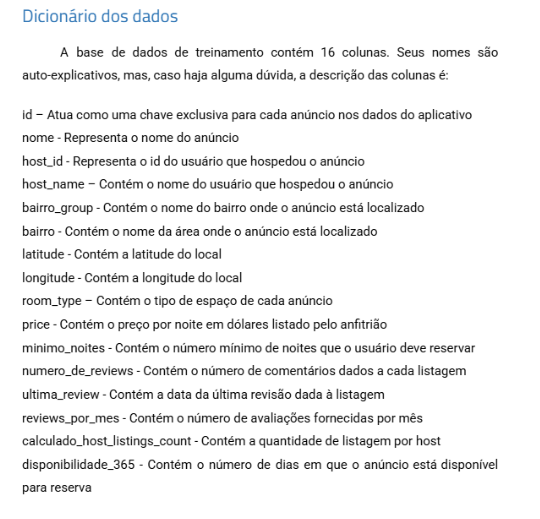

In [35]:
data_ml = data.drop(columns = ['id', 'host_id', 'host_name', 'nome'])

In [36]:
data_ml.columns

Index(['bairro_group', 'bairro', 'latitude', 'longitude', 'room_type', 'price',
       'minimo_noites', 'numero_de_reviews', 'ultima_review',
       'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365'],
      dtype='object')

# Duas opções para tratar dados categóricos

## One-Hot Encoding (Codificação One-Hot)  
Variáveis categóricas possuem valores nominais, como a variável "pet" recebendo "dog" ou "cat", ou a variável "color" recebendo "red" ou "black". A variável "place" pode assumir valores como "first" ou "second", sendo considerada uma variável ordinal.

O problema é que essas variáveis categóricas não são ideais para muitos modelos de machine learning, então precisamos converter esses dados em entradas numéricas.

Nesse processo, precisamos de duas etapas:  
1. **Codificação por números inteiros (Integer Encoding)**  
2. **Codificação One-Hot (One-Hot Encoding)**  

### **Integer Encoding**  
Por exemplo, "red" é representado por 1, "blue" por 2 e "green" por 3. Para algumas variáveis, essa etapa já é suficiente, como para variáveis ordinais, como "place".

### **One-Hot Encoding**  
Para variáveis sem relação ordinal, a codificação por números inteiros não é suficiente. No exemplo anterior, temos 3 categorias (red, green, blue), então organizamos esses valores em 3 colunas separadas
nment:image.png)

## **Label Encoding**  
Nesse caso, cada categoria recebe um número único. Por exemplo, "apple" é representado por 1, "banana" por 2 e "grapefruit" por 3. Essa abordagem é mais recomendada para variáveis ordinais, mas também pode ser usada para variáveis não ordinais, caso existam muitas categorias e a codificação One-Hot não seja viável.


In [37]:
data_ml['bairro_group'].nunique()

5

In [38]:
data_ml['room_type'].nunique()

3

In [39]:
data_ml['bairro'].nunique()

221

## Label Encoding e One-Hot Encoding

- Como "bairro_group" e "room_type" tem poucas categorias, sem relação ordinal, é possível utilizar-se o One-Hot Encoding sem causar alta dimensionalidade dos dados
- Entretanto, "bairro", por haver 221 categorias, isso ocasionaria a criação de mais 221 colunas, de forma que seja mais adequado, para não ter uma dimensão muito grande de dados e influenciar altamente o modelo, é mais adequado utilizar-se o Label Encoding

### Aplicando One-Hot Encoding

In [40]:
data_ml = pd.get_dummies(data_ml, columns=['bairro_group'], dtype=int)
data_ml = pd.get_dummies(data_ml, columns=['room_type'], dtype=int)

In [41]:
data_ml.head()

bairro  latitude  longitude  price  minimo_noites  numero_de_reviews  \
0       Midtown  40.75362  -73.98377    225              1                 45   
1        Harlem  40.80902  -73.94190    150              3                  0   
2  Clinton Hill  40.68514  -73.95976     89              1                270   
3   East Harlem  40.79851  -73.94399     80             10                  9   
4   Murray Hill  40.74767  -73.97500    200              3                 74   

  ultima_review  reviews_por_mes  calculado_host_listings_count  \
0    2019-05-21             0.38                              2   
1           NaN              NaN                              1   
2    2019-07-05             4.64                              1   
3    2018-11-19             0.10                              1   
4    2019-06-22             0.59                              1   

   disponibilidade_365  bairro_group_Bronx  bairro_group_Brooklyn  \
0                  355                   0                      0   
1                  365                   0                      0   
2                  194                   0                      1   
3                    0                   0                      0   
4                  129                   0                      0   

   bairro_group_Manhattan  bairro_group_Queens  bairro_group_Staten Island  \
0                       1                    0                           0   
1                       1                    0                           0   
2                       0                    0                           0   
3                       1                    0                           0   
4                       1                    0                           0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  
0                          1                       0                      0  
1                          0                       1                      0  
2                          1                       0                      0  
3                          1                       0                      0  
4                          1                       0                      0

### Aplicando Label Encoding

In [42]:
encoder = LabelEncoder()
data_ml['bairro'] = encoder.fit_transform(data_ml['bairro'])

In [43]:
data_ml.head()

bairro  latitude  longitude  price  minimo_noites  numero_de_reviews  \
0     127  40.75362  -73.98377    225              1                 45   
1      94  40.80902  -73.94190    150              3                  0   
2      41  40.68514  -73.95976     89              1                270   
3      61  40.79851  -73.94399     80             10                  9   
4     137  40.74767  -73.97500    200              3                 74   

  ultima_review  reviews_por_mes  calculado_host_listings_count  \
0    2019-05-21             0.38                              2   
1           NaN              NaN                              1   
2    2019-07-05             4.64                              1   
3    2018-11-19             0.10                              1   
4    2019-06-22             0.59                              1   

   disponibilidade_365  bairro_group_Bronx  bairro_group_Brooklyn  \
0                  355                   0                      0   
1                  365                   0                      0   
2                  194                   0                      1   
3                    0                   0                      0   
4                  129                   0                      0   

   bairro_group_Manhattan  bairro_group_Queens  bairro_group_Staten Island  \
0                       1                    0                           0   
1                       1                    0                           0   
2                       0                    0                           0   
3                       1                    0                           0   
4                       1                    0                           0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  
0                          1                       0                      0  
1                          0                       1                      0  
2                          1                       0                      0  
3                          1                       0                      0  
4                          1                       0                      0

## Transformação de Data (ultima review)
- Criou-se 3 colunas
    - ano
    - mes
    - dia
    - dia_da_semana
- Objetivo: identificar padrões cíclicos


In [44]:
data_ml['ultima_review'] = pd.to_datetime(data['ultima_review'])

# Extração dos componentes de data
data_ml['ano'] = data_ml['ultima_review'].dt.year
data_ml['mes'] = data_ml['ultima_review'].dt.month
data_ml['dia'] = data_ml['ultima_review'].dt.day
data_ml['dia_da_semana'] = data_ml['ultima_review'].dt.weekday  # 0=segunda-feira, 6=domingo

In [45]:
data_ml.head()

bairro  latitude  longitude  price  minimo_noites  numero_de_reviews  \
0     127  40.75362  -73.98377    225              1                 45   
1      94  40.80902  -73.94190    150              3                  0   
2      41  40.68514  -73.95976     89              1                270   
3      61  40.79851  -73.94399     80             10                  9   
4     137  40.74767  -73.97500    200              3                 74   

  ultima_review  reviews_por_mes  calculado_host_listings_count  \
0    2019-05-21             0.38                              2   
1           NaT              NaN                              1   
2    2019-07-05             4.64                              1   
3    2018-11-19             0.10                              1   
4    2019-06-22             0.59                              1   

   disponibilidade_365  bairro_group_Bronx  bairro_group_Brooklyn  \
0                  355                   0                      0   
1                  365                   0                      0   
2                  194                   0                      1   
3                    0                   0                      0   
4                  129                   0                      0   

   bairro_group_Manhattan  bairro_group_Queens  bairro_group_Staten Island  \
0                       1                    0                           0   
1                       1                    0                           0   
2                       0                    0                           0   
3                       1                    0                           0   
4                       1                    0                           0   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                          1                       0                      0   
1                          0                       1                      0   
2                          1                       0                      0   
3                          1                       0                      0   
4                          1                       0                      0   

      ano   mes   dia  dia_da_semana  
0  2019.0   5.0  21.0            1.0  
1     NaN   NaN   NaN            NaN  
2  2019.0   7.0   5.0            4.0  
3  2018.0  11.0  19.0            0.0  
4  2019.0   6.0  22.0            5.0

In [46]:
data_ml = data_ml.drop(columns = ['ultima_review'])

In [47]:
data_ml.isnull().sum()

bairro                               0
latitude                             0
longitude                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
bairro_group_Bronx                   0
bairro_group_Brooklyn                0
bairro_group_Manhattan               0
bairro_group_Queens                  0
bairro_group_Staten Island           0
room_type_Entire home/apt            0
room_type_Private room               0
room_type_Shared room                0
ano                              10052
mes                              10052
dia                              10052
dia_da_semana                    10052
dtype: int64

## Substituindo Valores Ausentes

- Média: dados simétricos com poucos outliers, ideal para dados contínuos com distribuição normal
- Mediana: dados assimétricos com outliers, ideal para variáveis ordinais ou com distribuição não normal
- Moda: variáveis categóricas ou discretas, com uma variável muito mais comum que a outra

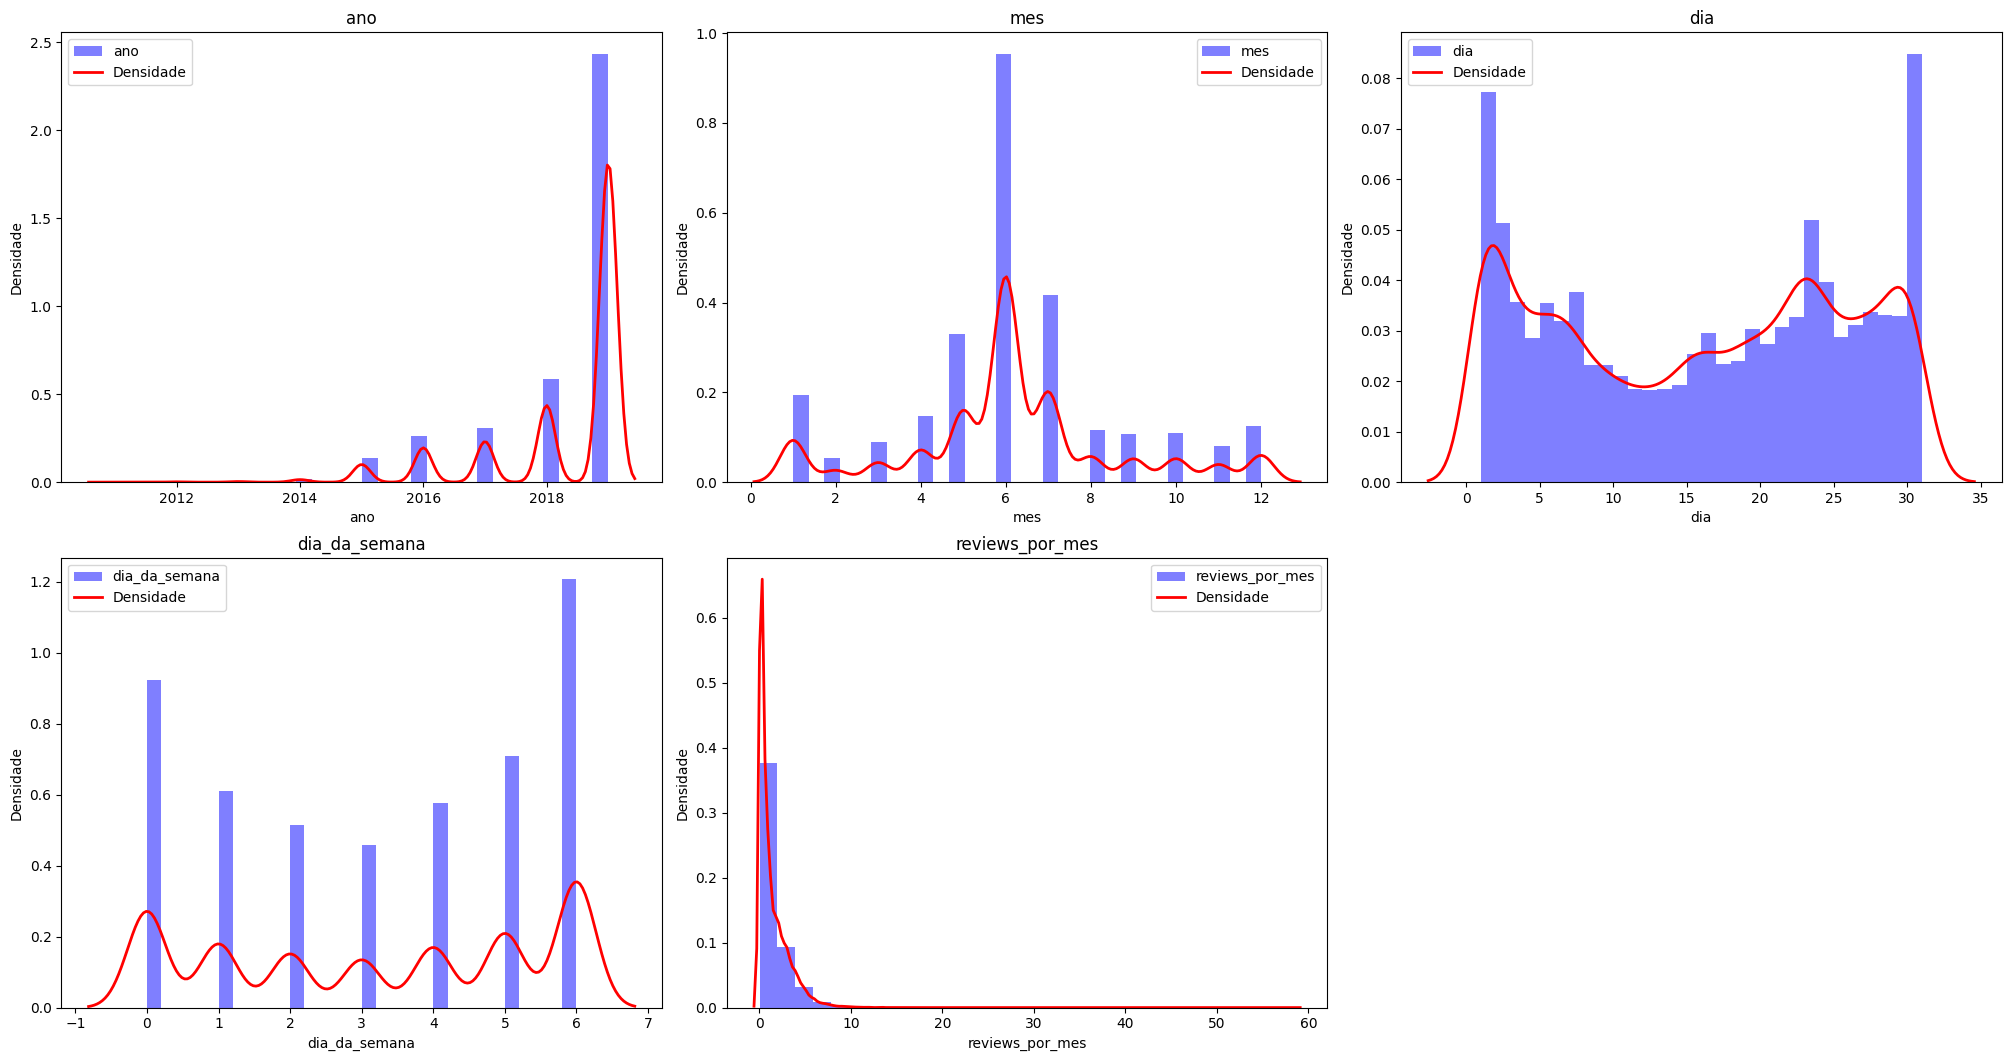

In [48]:
histograms(data_ml[['ano', 'mes', 'dia', 'dia_da_semana', 'reviews_por_mes']], drop_outliers = False)

In [49]:
normality_results = check_normality(data_ml[['ano', 'mes', 'dia', 'dia_da_semana', 'reviews_por_mes']])

# Exibindo os resultados
normality_results

C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 38842.
  res = hypotest_fun_out(*samples, **kwds)


column        shapiro  shapiro_normal  anderson_darling  \
0              ano  1.417254e-123               0       5665.263790   
1              mes   4.941417e-85               0       1304.887115   
2              dia   6.610528e-86               0        922.649281   
3    dia_da_semana   1.091644e-97               0       1623.075334   
4  reviews_por_mes  8.602992e-115               0       2568.007967   

   anderson_normal    jarque_bera  jarque_normal  d_agostino_pearson  \
0                0   0.000000e+00              0        0.000000e+00   
1                0  3.503134e-114              0        4.617560e-89   
2                0   0.000000e+00              0        0.000000e+00   
3                0   0.000000e+00              0        0.000000e+00   
4                0   0.000000e+00              0        0.000000e+00   

   d_agostino_normal  kolmogorov_smirnov  kolmogorov_normal  
0                  0               0.001                  0  
1                  0               0.001                  0  
2                  0               0.001                  0  
3                  0               0.001                  0  
4                  0               0.001                  0

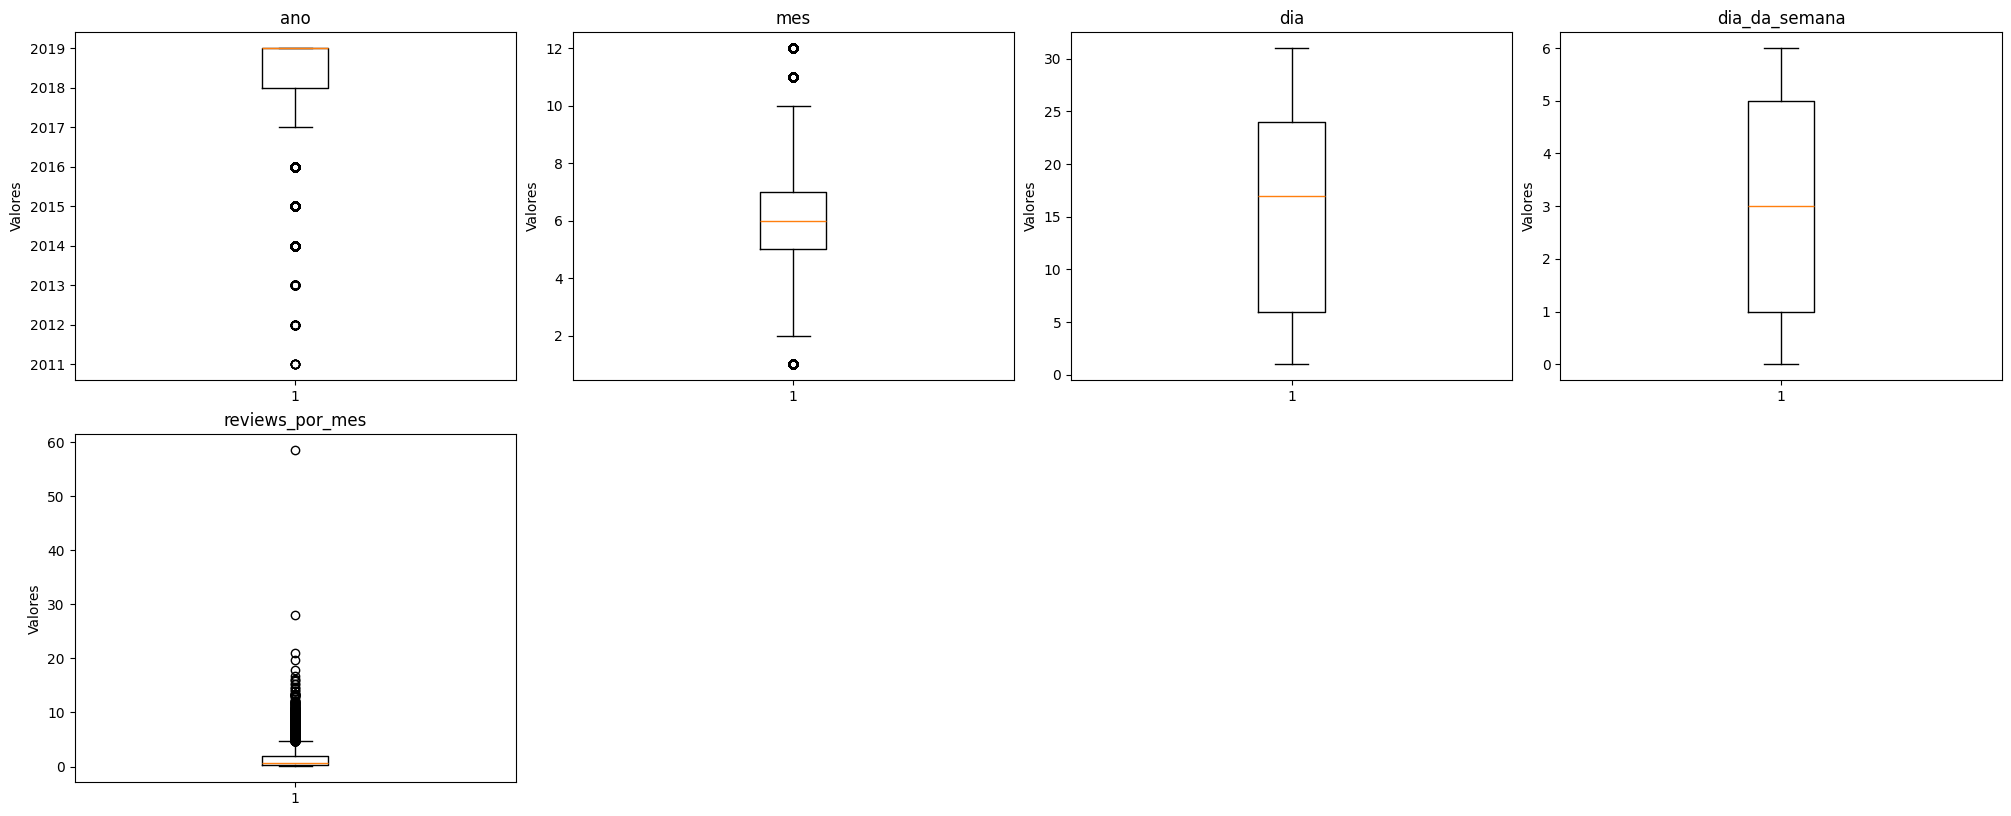

In [50]:
create_box_plots(data_ml[['ano', 'mes', 'dia', 'dia_da_semana', 'reviews_por_mes']], nrows = 4, ncols = 4)


### Decisão
 - Dado o comportamento dos dados, decidiu-se substituir os valores ausentes pela mediana

In [51]:
"""
    Substitui os valores NaN de uma coluna pela mediana da coluna.

    Parâmetros
    data_mediana = conjunto de dados em DataFrame (pandas)
    col = nome da coluna onde os NaN serão substituídos pela mediana
    
    Retorno
    Retorna o DataFrame com os valores NaN substituídos pela mediana na coluna especificada.
"""
def substituir_por_mediana(data_mediana, col):

    ## Para cada coluna, substitui os NaN pela mediana
    data_mediana[col] = data_mediana[col].fillna(data_mediana[col].median())
    
    return data_mediana

In [52]:
for col in ['ano', 'mes', 'dia', 'dia_da_semana', 'reviews_por_mes']:
    data_ml = substituir_por_mediana(data_ml, col)

In [53]:
data_ml.isnull().sum()

bairro                           0
latitude                         0
longitude                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
bairro_group_Bronx               0
bairro_group_Brooklyn            0
bairro_group_Manhattan           0
bairro_group_Queens              0
bairro_group_Staten Island       0
room_type_Entire home/apt        0
room_type_Private room           0
room_type_Shared room            0
ano                              0
mes                              0
dia                              0
dia_da_semana                    0
dtype: int64

## Transformação Yeo-Johson
- Uso de Yeo-Johnson, que diminui o impacto dos outliers e normaliza os dados

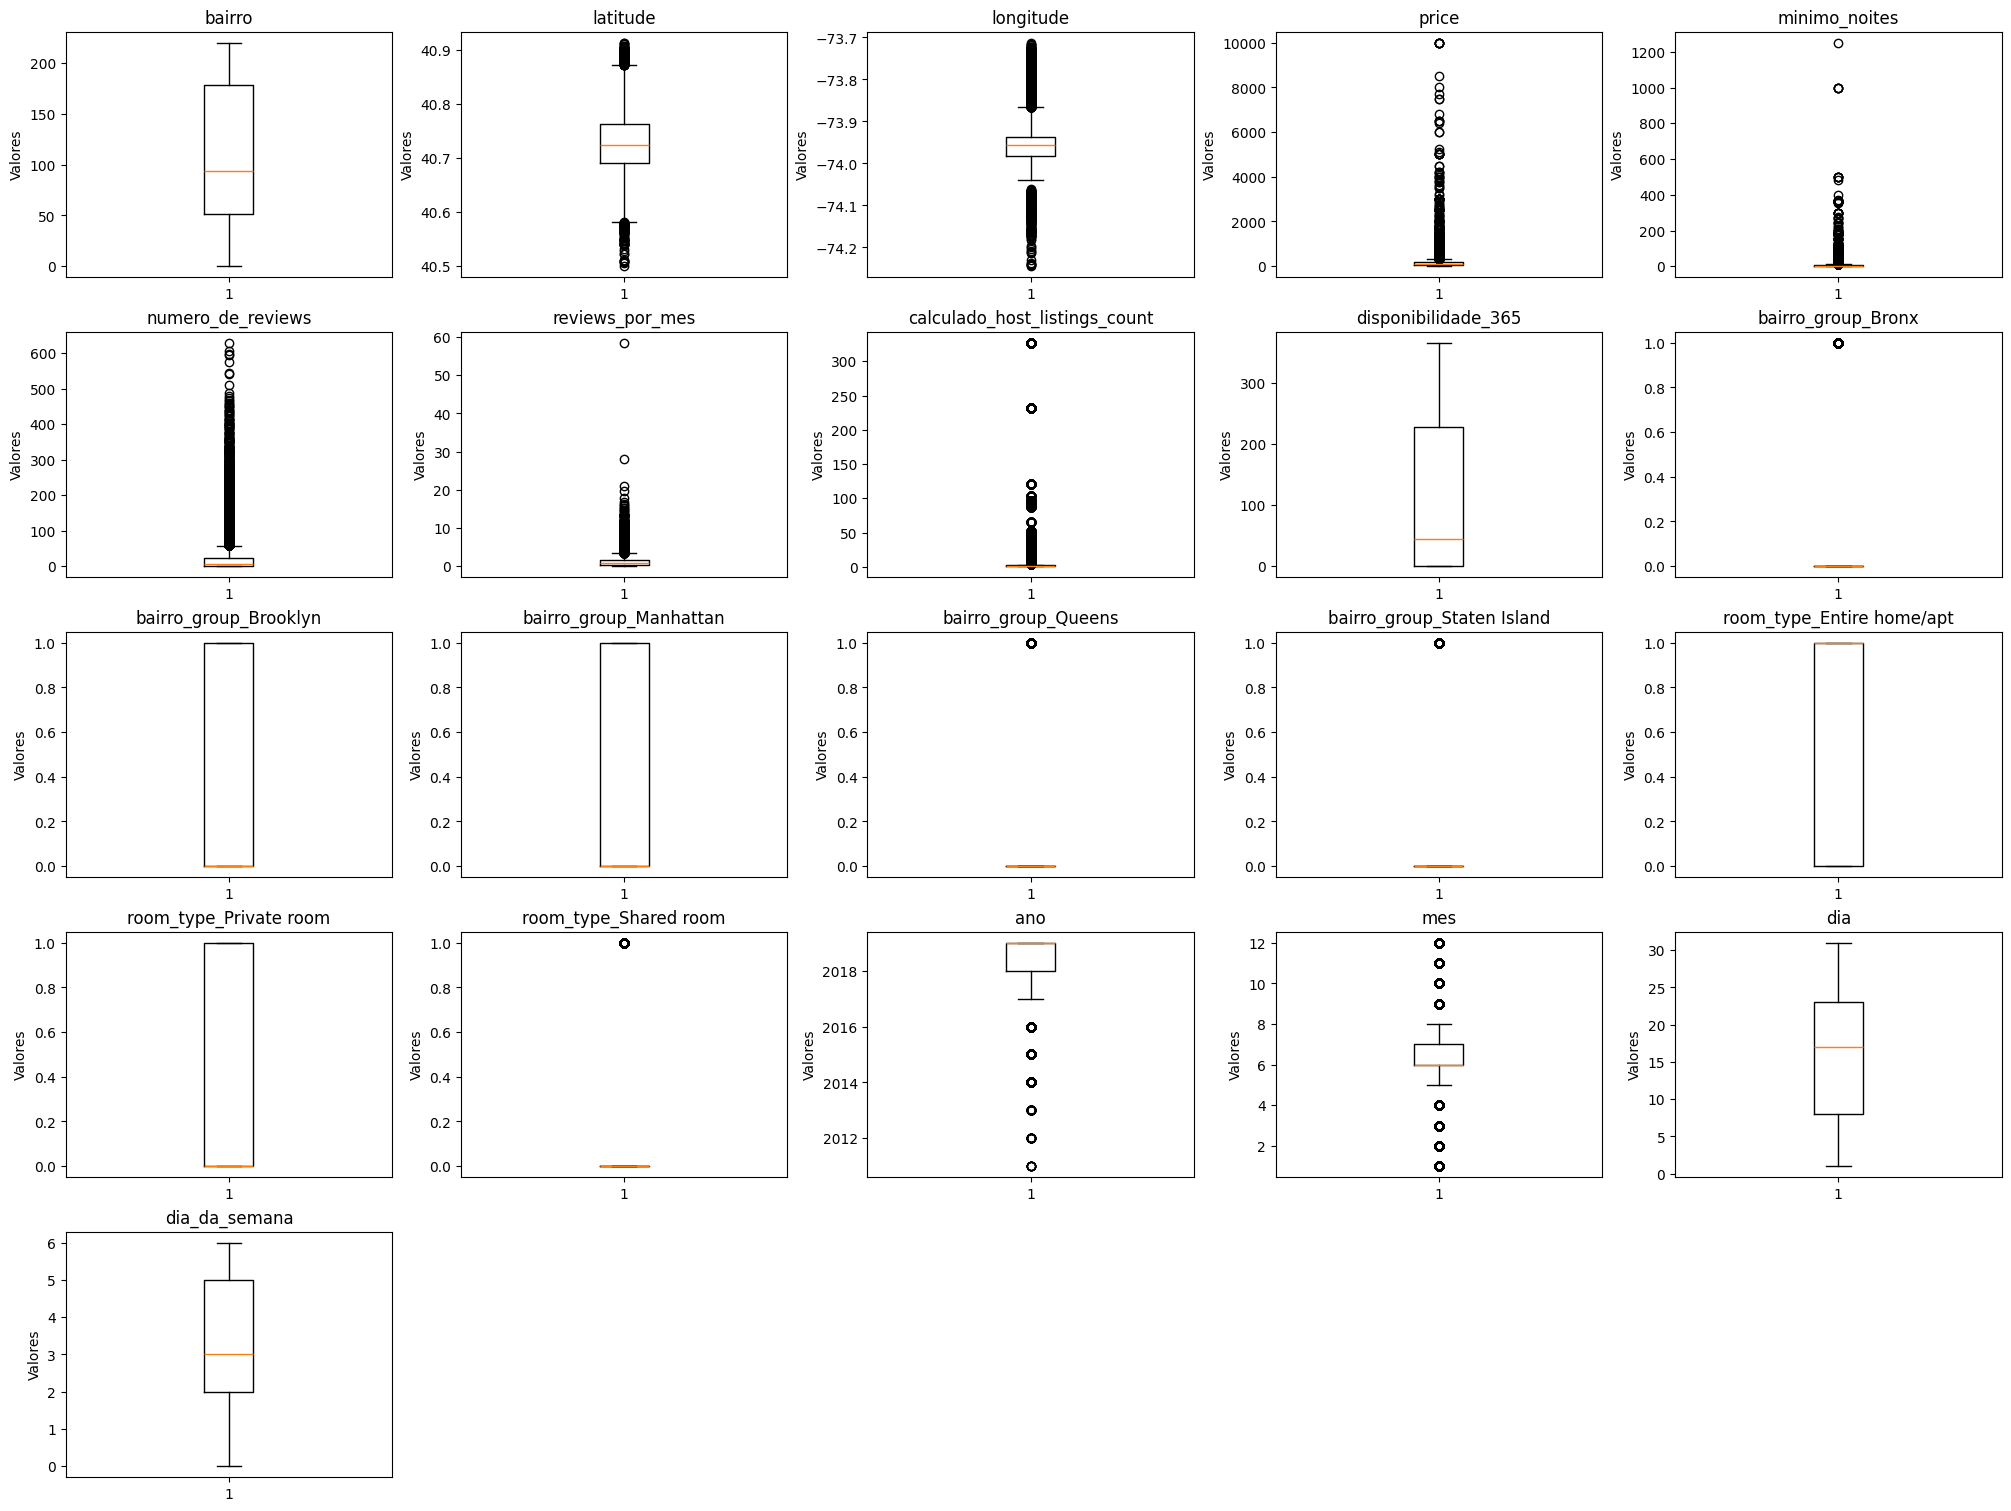

In [54]:
create_box_plots(data_ml, nrows = 5, ncols = 5)

In [55]:
data_ml = data_transformation("yeo-johnson", data_ml, columns = ['price', 'minimo_noites',
                                                                 'numero_de_reviews','reviews_por_mes',
                                                                 'calculado_host_listings_count' ], save_model = True,
                             model_filename_prefix='power_transformer_model')


Modelo para a coluna 'price' salvo em modelos_transfomacao_dados/power_transformer_model_price.pkl
Modelo para a coluna 'minimo_noites' salvo em modelos_transfomacao_dados/power_transformer_model_minimo_noites.pkl
Modelo para a coluna 'numero_de_reviews' salvo em modelos_transfomacao_dados/power_transformer_model_numero_de_reviews.pkl
Modelo para a coluna 'reviews_por_mes' salvo em modelos_transfomacao_dados/power_transformer_model_reviews_por_mes.pkl
Modelo para a coluna 'calculado_host_listings_count' salvo em modelos_transfomacao_dados/power_transformer_model_calculado_host_listings_count.pkl


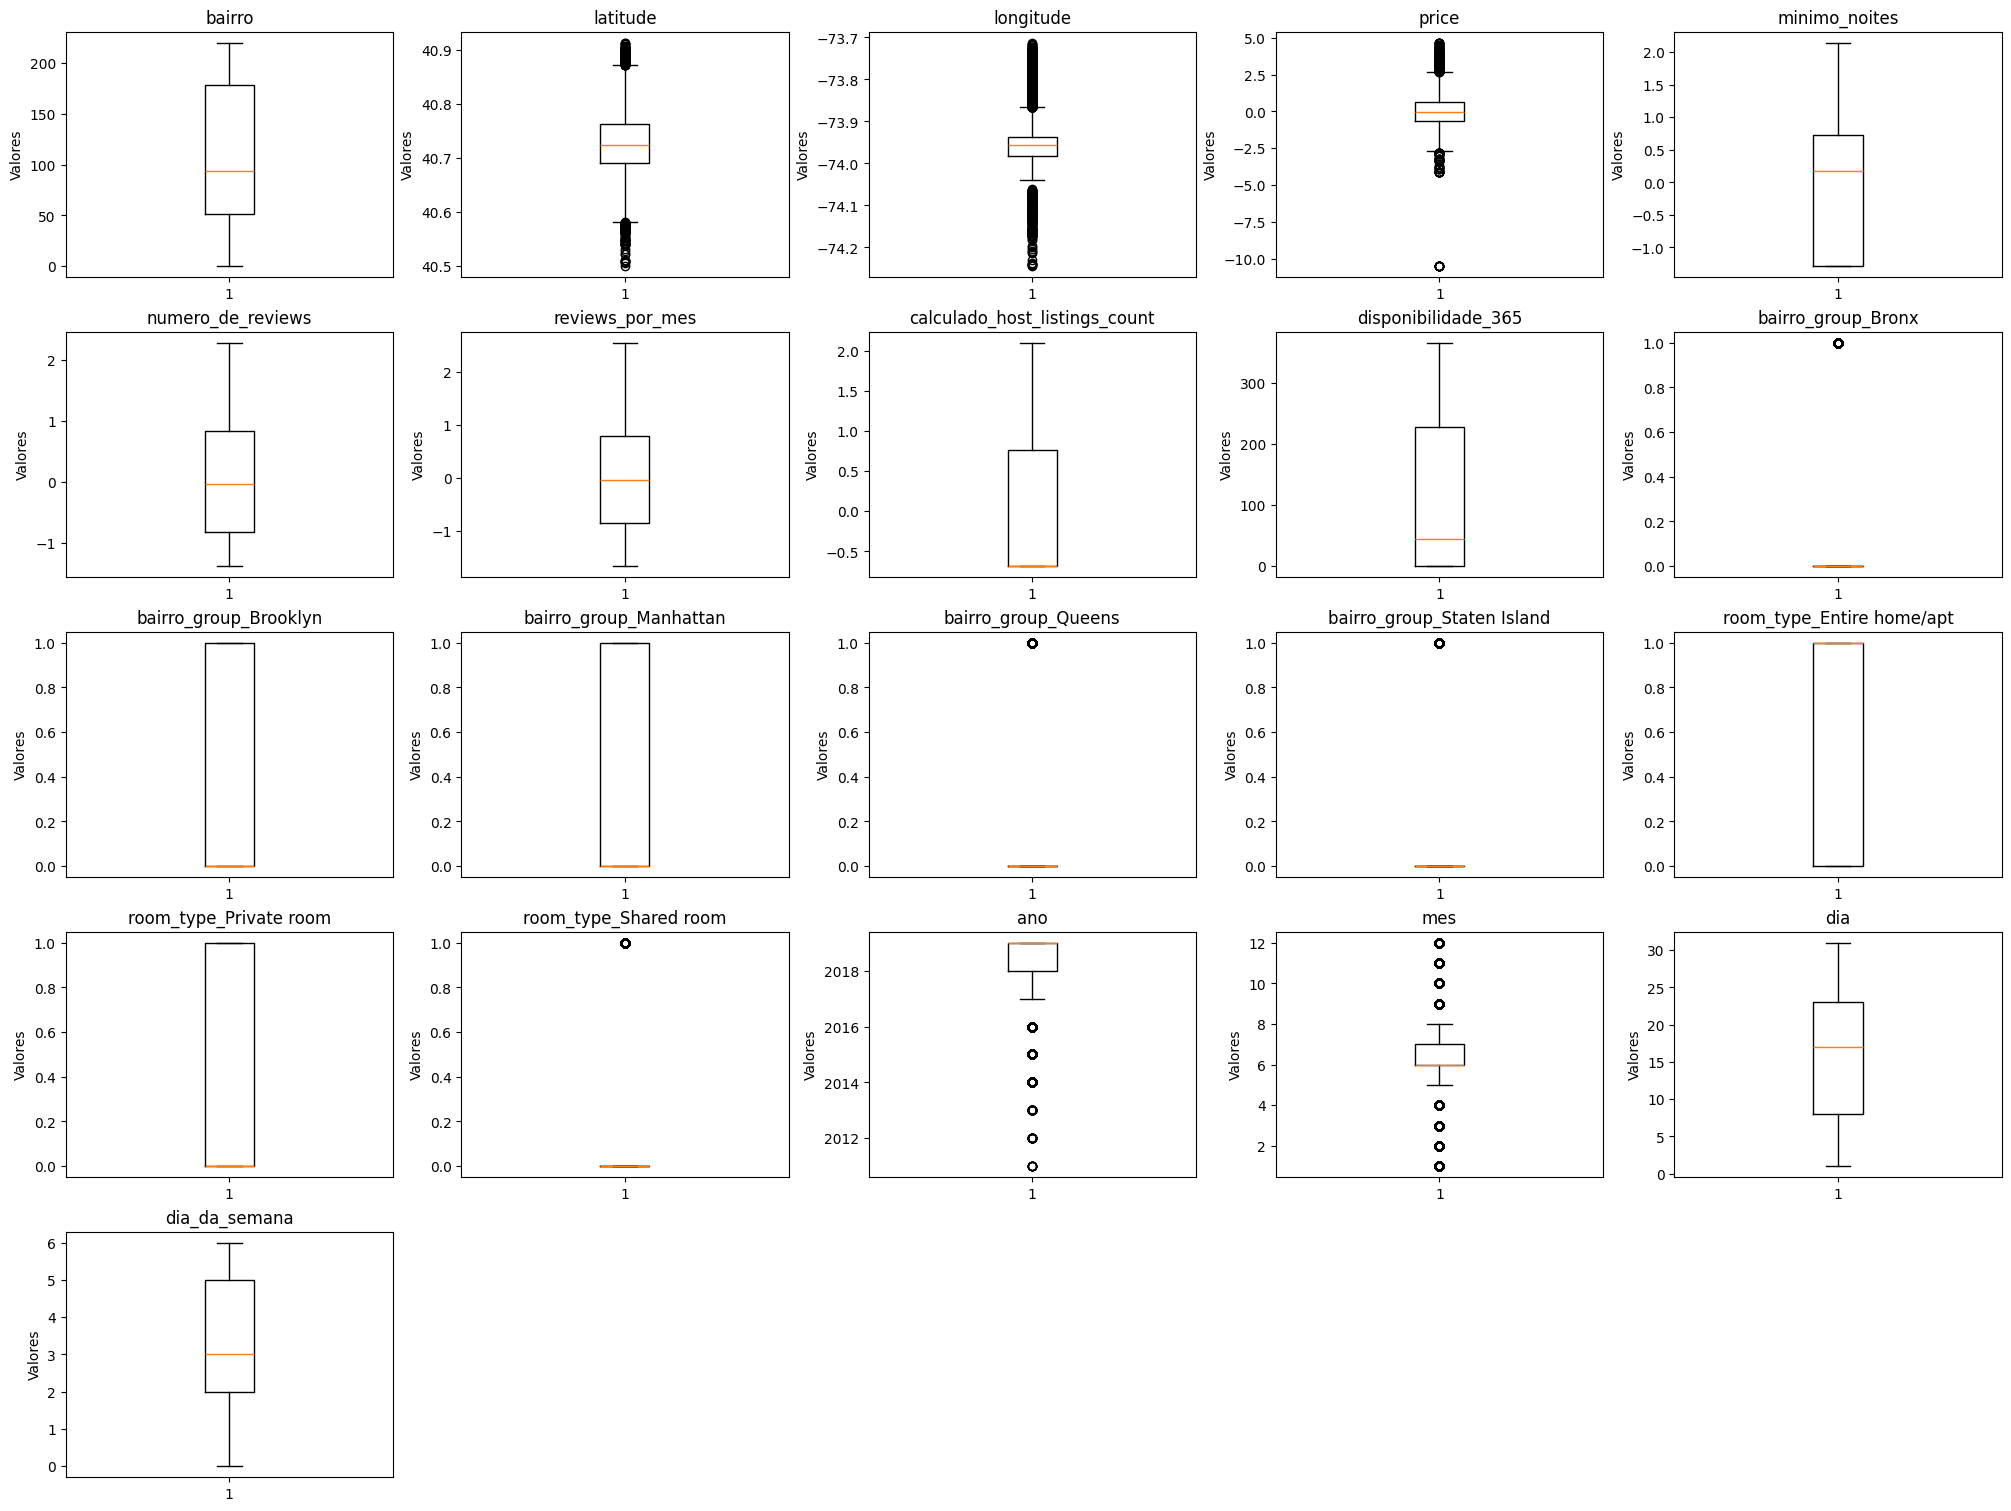

In [56]:
create_box_plots(data_ml, nrows = 5, ncols = 5)

## Normalização dos Dados
### MinMaxScaler (sklearn)

- Escala os dados colocando-os em um intervalo de 0 a 1, -1 a 1 se tiverem negativos (normalizar)
- Na presença de outliers, não garante escalas de recursos balanceadas, devido à influência dos outliers
- Funciona melhor em dados com distribuição não normal e desvio padrão pequeno
### Standard Scaler (sklearn)

- Escala os dados, mas a maioria fica em um intervalo de -3 e 3 (normalizar)
- Remove a média (atribui a 0 ) e o desvio padrão a 1 , para cada feature (padronização)
- Não garante dados muito equilibrados na presença de outliers
- Funciona bem com algoritmos de Linear Regression e Logistic Regression.
- Funciona melhor em dados com Distribuição Normal

### Robust Scaler
- Com o uso deles, pode-se remover os outliers e usar StandardScaler ou MinMaxScaler para pré-processar o conjunto de dados
- Remove a mediana e dimensiona os dados no intervalo interquartil (1 e 3)

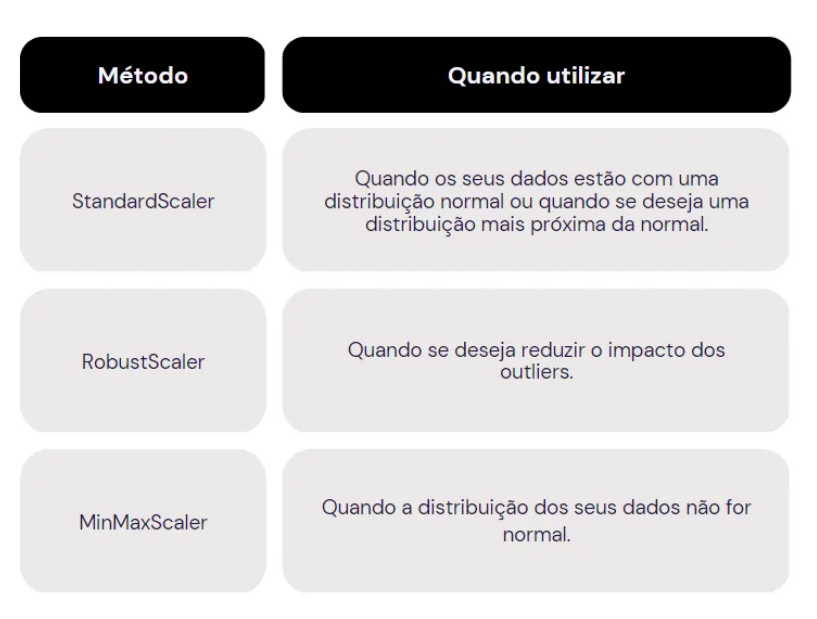

In [57]:
"""
    Aplica a transformação de escalonamento Min-Max em todas as colunas numéricas de um DataFrame.

    Parâmetros
    data = conjunto de dados em DataFrame (pandas)
    
    Retorno
    Retorna o DataFrame com os dados transformados pelo Min-Max Scaling.
    
"""
def data_transformation_MinMaxScaler(data):
    data_cleaned = data.copy()
    
    ## Dicionário para armazenar os escaladores de cada coluna
    scalers = {}
   
    for col in data_cleaned.columns:
        ## Instanciando o scaler para cada coluna
        scaler = MinMaxScaler()
        
        ## Ajustando e transformando os dados da coluna
        data_cleaned[col] = scaler.fit_transform(data_cleaned[[col]])
        
        ## Salvando o scaler no dicionário
        scalers[col] = scaler
        
        print(f"Transformação na coluna '{col}' aplicada com sucesso.")
    
    ## Salvando os escaladores com joblib
    joblib.dump(scalers, "modelos_transfomacao_dados/scalers_model.pkl")
    print("Modelos de escalonamento salvos com sucesso!")
    
    return data_cleaned


In [58]:
data_ml = data_transformation_MinMaxScaler(data_ml)

Transformação na coluna 'bairro' aplicada com sucesso.
Transformação na coluna 'latitude' aplicada com sucesso.
Transformação na coluna 'longitude' aplicada com sucesso.
Transformação na coluna 'price' aplicada com sucesso.
Transformação na coluna 'minimo_noites' aplicada com sucesso.
Transformação na coluna 'numero_de_reviews' aplicada com sucesso.
Transformação na coluna 'reviews_por_mes' aplicada com sucesso.
Transformação na coluna 'calculado_host_listings_count' aplicada com sucesso.
Transformação na coluna 'disponibilidade_365' aplicada com sucesso.
Transformação na coluna 'bairro_group_Bronx' aplicada com sucesso.
Transformação na coluna 'bairro_group_Brooklyn' aplicada com sucesso.
Transformação na coluna 'bairro_group_Manhattan' aplicada com sucesso.
Transformação na coluna 'bairro_group_Queens' aplicada com sucesso.
Transformação na coluna 'bairro_group_Staten Island' aplicada com sucesso.
Transformação na coluna 'room_type_Entire home/apt' aplicada com sucesso.
Transformação

In [59]:
min_max_values = data_ml.describe().loc[['min', 'max']]
print(min_max_values)


     bairro  latitude  longitude  price  minimo_noites  numero_de_reviews  \
min     0.0       0.0        0.0    0.0            0.0                0.0   
max     1.0       1.0        1.0    1.0            1.0                1.0   

     reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
min              0.0                            0.0                  0.0   
max              1.0                            1.0                  1.0   

     bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
min                 0.0                    0.0                     0.0   
max                 1.0                    1.0                     1.0   

     bairro_group_Queens  bairro_group_Staten Island  \
min                  0.0                         0.0   
max                  1.0                         1.0   

     room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
min                        0.0                     0.0            

## Verificando novamente matriz de correlação

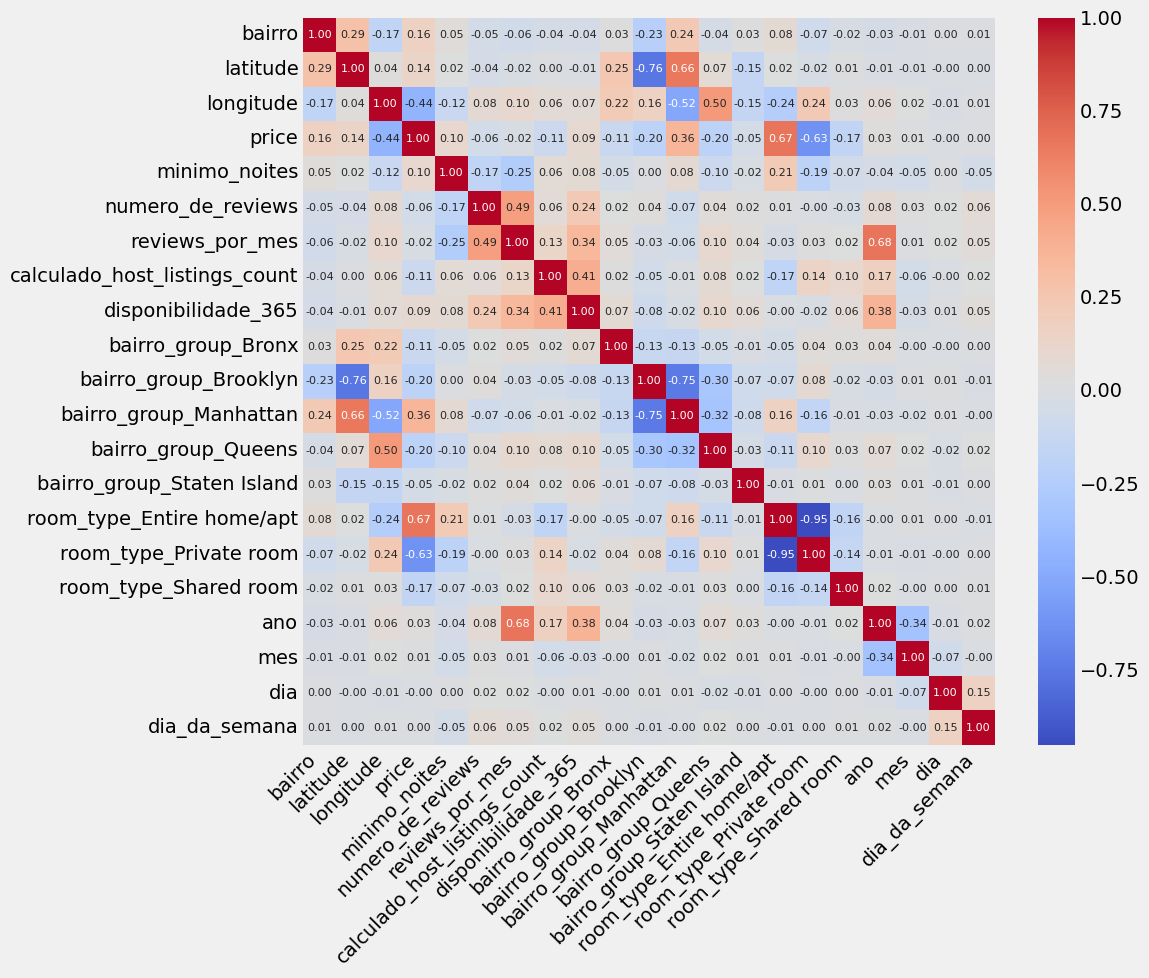

In [104]:
correlation_matrix(data_ml, "spearman", quantity = int(data_ml.shape[0]),  ascending = True)

## Separação em dados de Teste e de Treino

Quando treinamos nosso modelo, precisamos separar os dados em duas partes: uma responsável pelo treinamento do modelo e outra para testá-lo. Na parte responsável pelo treinamento, os rótulos estão disponíveis, mas nos testes, não. Isso é semelhante à escola: estudamos com o material de apoio e fazemos as provas sem ele.

Dividimos os dados aleatoriamente porque, se pegarmos (por exemplo) as primeiras 60 linhas para testar e o restante para treinar, o modelo só conhecerá o comportamento da temperatura em meses que não sejam janeiro ou fevereiro, o que resultaria em um treinamento fraco.

In [60]:
data_test = data_ml.copy()
labels = np.array(data_test['price'])
features = data_test.drop('price', axis = 1)

feature_list = list(features.columns)

features = np.array(features)

In [61]:
train_features, test_features, train_labels,test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [62]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (36670, 20)
Training Labels Shape: (36670,)
Testing Features Shape: (12224, 20)
Testing Labels Shape: (12224,)


# Treino do Modelo

## Cross-validation 

- Medida preventiva de overfitting
- Separar os dados e gerar múltiplos train-test frações
- Permite tunar hiperparâmetros

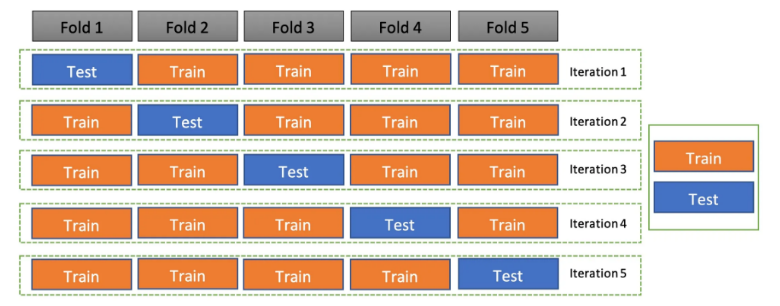

## Tunagem por Hiperparâmetros

Um hiperparâmetro é uma configuração externa ao modelo que não pode ser automaticamente estimado pelos dados fornecidos, devendo ser testado e avaliado. Diferentes escolhas de hiperparâmetros geram resultados diferentes nos testes do modelo.

Para escolher os melhores hiperparâmetros, temos duas possibilidades comuns:

- **GridSearch**: Faz todas as combinações de hiperparâmetros, testando o modelo para cada uma, e retorna os melhores hiperparâmetros possíveis (máximo global).
- **RandomizeSearch**: Testa aleatoriamente algumas combinações, não todas, e retorna o melhor resultado possível. É mais rápido em questão de processamento, mas pode não retornar o melhor resultado (máximo global), por trabalhar com amostras.

Será escolhido o **RandomizeSearch** para mais rápido processamento, mas o algoritmo para tratar o **GridSearch** é praticamente o mesmo, só mudando o nome da função.


In [63]:
"""
    Treina um modelo de regressão com base no nome do modelo fornecido e nos dados de treino.

    Parâmetros
    model_name = nome do modelo a ser treinado. Deve ser uma das opções: 
                 "LinearRegression", "RandomForestRegressor", "GradientBoostingRegressor",
                 "SVR", "BayesianRidge", "KNeighborsRegressor".
    train_features = características de treinamento (pandas DataFrame ou numpy array).
    train_labels = rótulos de treinamento (pandas Series ou numpy array).
    
    Retorno
    Retorna o modelo treinado após a busca aleatória para otimização de hiperparâmetros.
    
"""
def train_model(model_name, train_features, train_labels):
    if model_name == "LinearRegression":
        model = LinearRegression()
        param_grid = {'copy_X' : [True, False],
                'fit_intercept' : [True, False],
                'n_jobs' : [1,2,3],
                'positive' : [True, False]}

    elif model_name == "RandomForestRegressor":
        model = RandomForestRegressor()
        param_grid = {
            "n_estimators": [int(x) for x in np.linspace(200, 2000, 10)],
            "max_features": ['sqrt', 'log2', None],
            "max_depth": [int(x) for x in np.linspace(10, 110, 11)] + [None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        }

    elif model_name == "GradientBoostingRegressor":
        model = GradientBoostingRegressor()
        param_grid = {
            "n_estimators": [100, 200, 500],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10],
            "subsample": [0.7, 0.8, 1.0],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }

    elif model_name == "SVR":
        model = SVR()
        param_grid = {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 1, 10, 100],
            "gamma": ["scale", "auto"]
        }

    elif model_name == "BayesianRidge":
        model = BayesianRidge()
        param_grid = {
            "alpha_1": [1e-6, 1e-5, 1e-4],
            "alpha_2": [1e-6, 1e-5, 1e-4],
            "lambda_1": [1e-6, 1e-5, 1e-4],
            "lambda_2": [1e-6, 1e-5, 1e-4]
        }
    elif model_name == "KNeighborsRegressor":
        model = KNeighborsRegressor()
        param_grid = {
            "n_neighbors": [3, 5, 7, 10, 15, 20],  
            "weights": ['uniform', 'distance'],   
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [20, 30, 40, 50],        
            "p": [1, 2]  
        }
    else:
        raise ValueError("Modelo não reconhecido. Escolha entre: LinearRegression, RandomForestRegressor,GradientBoostingRegressor, SVR, BayesianRidge.")

    ## RandomizedSearchCV para otimizar os hiperparâmetros
    ## OBS: NÃO FOI USADO "GridSearchCV" por causa do CUSTO COMPUTACIONAL.
    ## Caso tivesse acesso a mais GPU, poderia-se usar GridSearch, afinal ela testa todas as possibilidades
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=30, cv=5,
                                       verbose=2, random_state=42, n_jobs=-1)
    random_search.fit(train_features, train_labels)

    return random_search


In [64]:
models = [
    "LinearRegression",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "SVR",
    "BayesianRidge",
    "KNeighborsRegressor"
]
# rf_model = train_model(models[1], train_features, train_labels)


In [65]:
# Treinando e salvando cada modelo individualmente
lr_model = train_model("LinearRegression", train_features, train_labels)
joblib.dump(lr_model, "modelos_machine_learning/LinearRegression.pkl")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


['modelos_machine_learning/LinearRegression.pkl']

In [66]:
br_model = train_model("BayesianRidge", train_features, train_labels)
joblib.dump(br_model, "modelos_machine_learning/BayesianRidge.pkl")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


['modelos_machine_learning/BayesianRidge.pkl']

In [67]:
knn_model = train_model("KNeighborsRegressor", train_features, train_labels)
joblib.dump(knn_model, "modelos_machine_learning/KNeighborsRegressor.pkl")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


['modelos_machine_learning/KNeighborsRegressor.pkl']

In [ ]:
rf_model = train_model("RandomForestRegressor", train_features, train_labels)
joblib.dump(rf_model, "modelos_machine_learning/RandomForestRegressor.pkl")

In [ ]:
gb_model = train_model("GradientBoostingRegressor", train_features, train_labels)
joblib.dump(gb_model, "modelos_machine_learning/GradientBoostingRegressor.pkl")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [72]:
svr_model = train_model("SVR", train_features, train_labels)
joblib.dump(svr_model, "modelos_machine_learning/SVR.pkl")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


['modelos_machine_learning/SVR.pkl']

## Carregando Modelos

In [65]:
lr_model = joblib.load("modelos_machine_learning/LinearRegression.pkl")
rf_model = joblib.load("modelos_machine_learning/RandomForestRegressor.pkl")
gb_model = joblib.load("modelos_machine_learning/GradientBoostingRegressor.pkl")
svr_model = joblib.load("modelos_machine_learning/SVR.pkl")
br_model = joblib.load("modelos_machine_learning/BayesianRidge.pkl")
knn_model = joblib.load("modelos_machine_learning/KNeighborsRegressor.pkl")

## Verificando Importancia das Variáveis (Random Forest Model, GradientBoostingRegressor)

In [66]:
"""
    Exibe as variáveis mais importantes de um modelo treinado.

    Parâmetros
    ----------
    model : modelo treinado com RandomizedSearchCV.
        O modelo que possui o melhor estimador e as importâncias das variáveis.
    feature_list : lista de nomes das variáveis/features.
        A lista contendo os nomes das variáveis correspondentes aos dados usados para treinar o modelo.
"""
def important_variables(model):
    ## conseguindo a importancia das variaveis
    importance = list(model.best_estimator_.feature_importances_)
    feature_importance = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importance)]
    
    ## organizando decrescentemente
    feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse = True)
    
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importance]
    plt.style.use('fivethirtyeight')

    x_values = list(range(len(importance)))
    ### Criando Gráfico
    plt.bar(x_values, importance, orientation = 'vertical')
    plt.xticks(x_values, feature_list, rotation = 'vertical')
    plt.ylabel('Importance')
    plt.xlabel('Variable')
    plt.title('Variable Importances')

Variable: room_type_Entire home/apt Importance: 0.25
Variable: room_type_Private room Importance: 0.18
Variable: longitude            Importance: 0.13
Variable: latitude             Importance: 0.09
Variable: disponibilidade_365  Importance: 0.05
Variable: bairro               Importance: 0.04
Variable: bairro_group_Manhattan Importance: 0.04
Variable: minimo_noites        Importance: 0.03
Variable: numero_de_reviews    Importance: 0.03
Variable: reviews_por_mes      Importance: 0.03
Variable: calculado_host_listings_count Importance: 0.03
Variable: room_type_Shared room Importance: 0.03
Variable: dia                  Importance: 0.02
Variable: bairro_group_Brooklyn Importance: 0.01
Variable: bairro_group_Queens  Importance: 0.01
Variable: ano                  Importance: 0.01
Variable: mes                  Importance: 0.01
Variable: dia_da_semana        Importance: 0.01
Variable: bairro_group_Bronx   Importance: 0.0
Variable: bairro_group_Staten Island Importance: 0.0


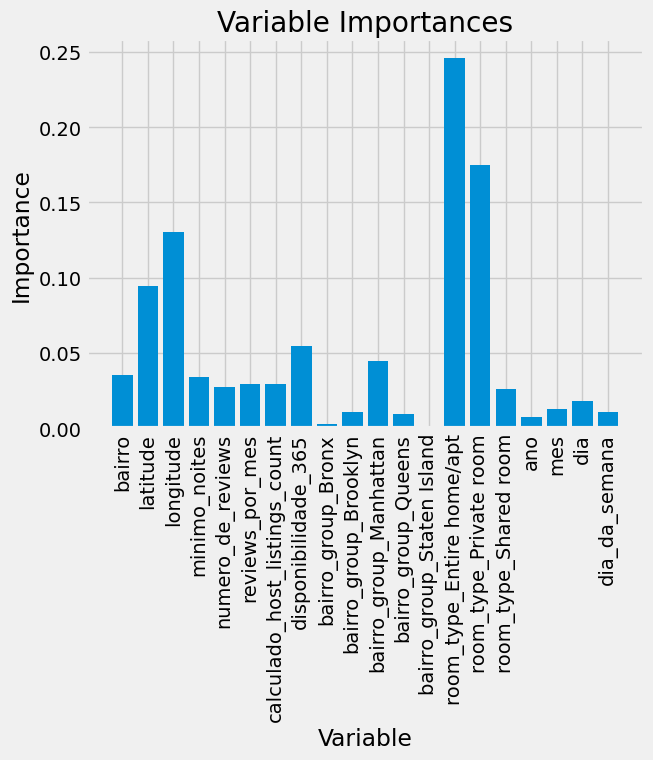

In [67]:
important_variables(rf_model)

Variable: room_type_Entire home/apt Importance: 0.45
Variable: longitude            Importance: 0.12
Variable: latitude             Importance: 0.11
Variable: disponibilidade_365  Importance: 0.06
Variable: minimo_noites        Importance: 0.04
Variable: bairro_group_Manhattan Importance: 0.04
Variable: numero_de_reviews    Importance: 0.03
Variable: reviews_por_mes      Importance: 0.03
Variable: calculado_host_listings_count Importance: 0.03
Variable: bairro               Importance: 0.02
Variable: dia                  Importance: 0.02
Variable: room_type_Private room Importance: 0.01
Variable: room_type_Shared room Importance: 0.01
Variable: ano                  Importance: 0.01
Variable: mes                  Importance: 0.01
Variable: dia_da_semana        Importance: 0.01
Variable: bairro_group_Bronx   Importance: 0.0
Variable: bairro_group_Brooklyn Importance: 0.0
Variable: bairro_group_Queens  Importance: 0.0
Variable: bairro_group_Staten Island Importance: 0.0


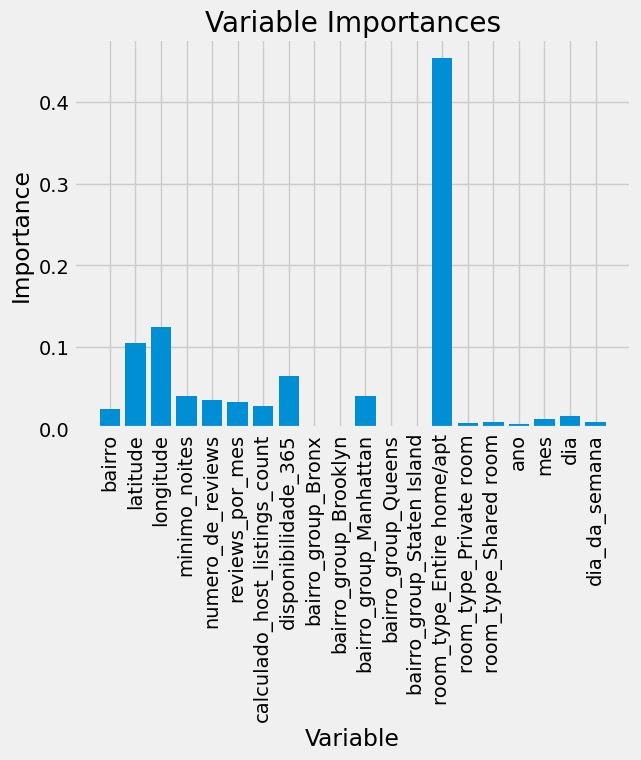

In [68]:
important_variables(gb_model)

# Métricas de Avaliação de Modelo de Machine Learning - Regressão

- A ideia das métricas baseia-se na mesma ideia: o cálculo da diferença entre o valor real e o previsto


# R^2, R-dois ou coeficiente de determinação

- Percentual da variância dos dados que é explicado pelo modelo
- Variam de 0 a 1, mas podem vier em porcentagem de 0 a 100%
- Quanto maior o R^2, mais explicativo é o modelo em relação aos dados previstos

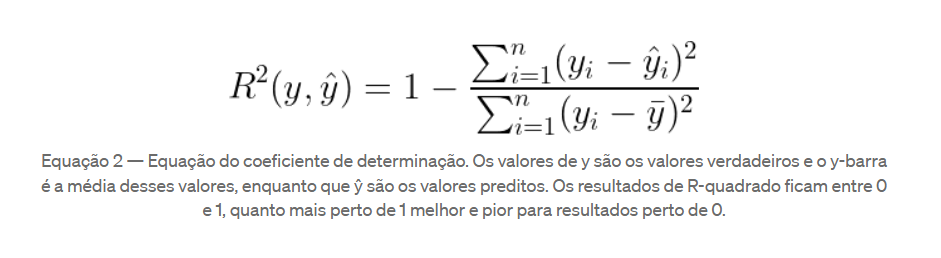

# MAE - (Mean Absolute Error) ou Erro Absoluto Médio

- Média da diferença entre o valor real e predito
- Por haver valores positivos e negativos, é adicionado um módulo na diferença dos valores (ou seja, se ele errar em um positivamente e no outro negativamente, esses erros não irão se anular)
- Essa métrica não é afetada por outliers

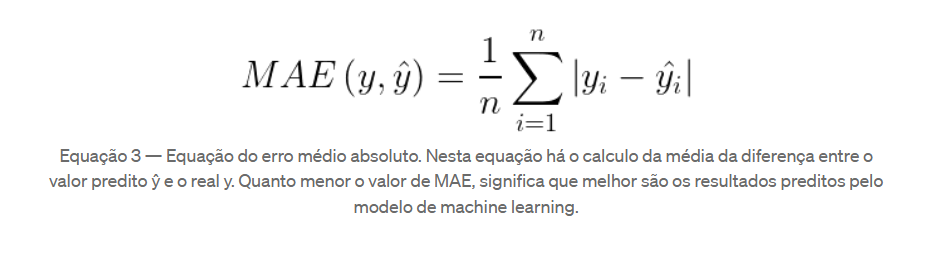

- O valor de saída da equação tem a mesma escala dos dados utilizados para previsão.
- Se o MAE for igual a 10 metros, significa que o modelo está errando 10 metros em média

# MAPE (Mean Absolute Percentual Error) ou Erro Percentual Absoluto Médio

- Mostra a porcentagem de erro em relação aos valores reais
- Se parece com o MAE, mas divide-se por |y|
- Se o MAPE for 40%, isso mostra que o modelo faz previsões que em média a diferença entre o valor previsto e o valor real equivale a 40% do valor real

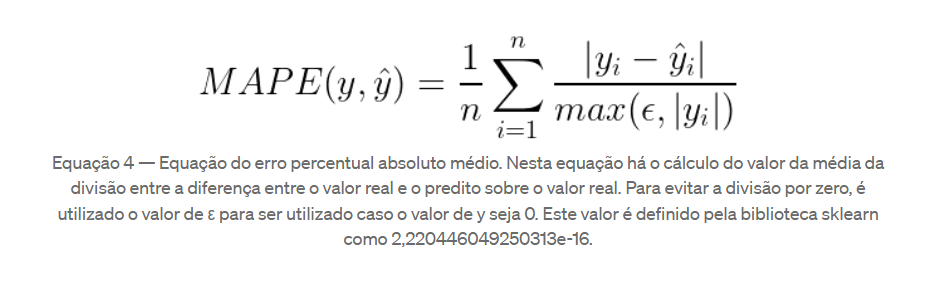

# MSE (Mean Squared Error) ou Erro Quadrático Médio
- Como o MAE, calcula a diferença média das diferenças entre o valor predito e o real, mas a diferença é elevada ao quadrado
- Essa métrica penaliza valores que sejam muito diferentes entre o previsto e o real

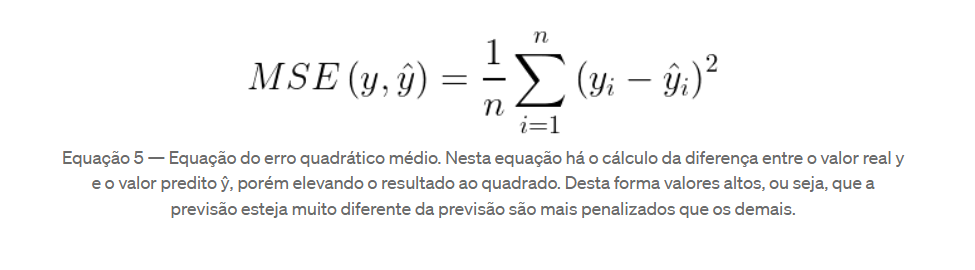

# RMSE (Root Mean Squared Error)
- Mesmo cálculo do MSE, mas aplica-se a raiz quadrada ao resultado
- Isso faz com que o resultado esteja na mesma escala dos dados
- Mais sensível aos outliers, essa métrica pode mostrar como os outliers estão impactando o modelo, diferente do MAE

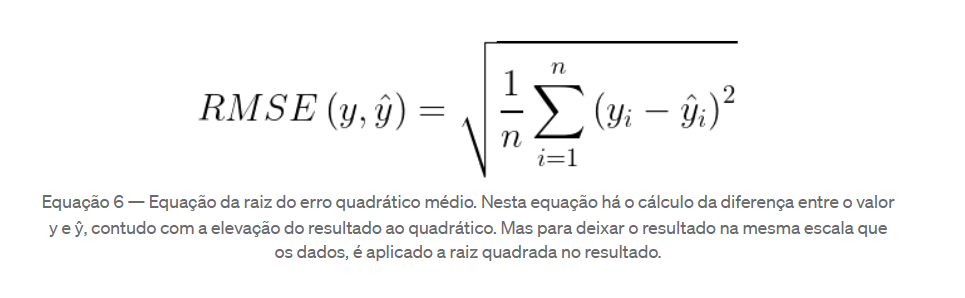

# SMAPE (Symmetric Mean Absolute Percentage Error) ou Erro Percentual Absoluto Médio Simétrico

- O SMAPE é uma variação do MAPE, mas com uma abordagem simétrica para evitar problemas quando os valores reais são muito pequenos ou zero.
- Mede a precisão do modelo em termos percentuais, sendo útil quando se deseja entender a taxa de erro relativa às previsões.
- Como o denominador usa a média entre o valor real e o previsto, o SMAPE evita valores extremas quando o valor real é próximo de zero.
- O resultado varia de 0% a 100%, onde 0% indica um modelo perfeito e 100% indica um modelo com erro máximo.

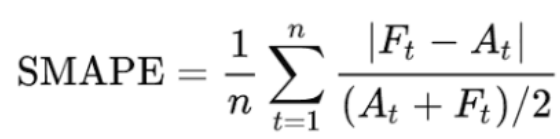
- Se o SMAPE for 20%, significa que, em média, a diferença absoluta entre o valor previsto e o real corresponde a 20% da média dos dois valores.
- Essa métrica é particularmente útil em séries temporais e problemas de previsão onde há valores pequenos ou flutuações significativas.



In [69]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    ## Erros absolutos
    errors = np.abs(predictions - test_labels)
    
    ## Mean Absolute Error (MAE)
    mae = mean_absolute_error(test_labels, predictions)
    
    ## Mean Squared Error (MSE)
    mse = mean_squared_error(test_labels, predictions)
    
    ## Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    ## R² Score
    r2 = r2_score(test_labels, predictions)
    
    ## Symmetric Mean Absolute Percentage Error (SMAPE)
    smape = 100 * np.mean(errors / ((np.abs(test_labels) + np.abs(predictions)) / 2))
    
    ## "Accuracy" como 100 - SMAPE
    accuracy = 100 - smape
    
    ## Exibir os resultados formatados
    print("Model Performance:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"SMAPE: {smape:.2f}%")
    print(f"Accuracy (100 - SMAPE): {accuracy:.2f}%")
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "SMAPE": smape,
        "Accuracy": accuracy
    }


# Linear Regression

- O modelo possui essa forma:

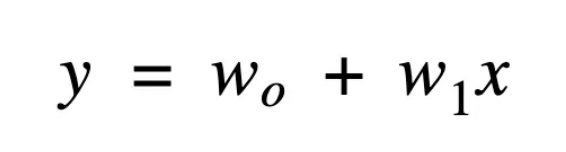

- y = variável alvo (target) ou variável dependente (em modelagem estatística), representa o valor contínuo a ser previsto
- x = feature de entrada ou variável indepentende (em estatística)
- w0 = termo de polarização ou interceptação do eixo y
- w1 = coeficiente de regressão ou fator de escala. Equivale à inclinação da reta
- O objetivo da modelagem é encontrar os valores dos pesos w0 e w1

- Funcionamento do Modelo:
   - Baseia-se na solução fechada dos mínimos quadrados, que usa álgebra linear para encontrar diretamente os melhores coeficientes
   - β = (Xᵀ X)⁻¹ Xᵀ y

   - X = matriz de features
   - Xᵀ = matris transposta de X
   - y = vetor de saída
## Vantagens
 - Fácil de ser aplicado e interpretado
 - Eficiente computacionalmente
## Desvantagens
 - Não funciona muito bem para relações não lineares entre variáveis
 - Sensibilidade a outliers
 - Multicolinearidade: quando as variáveis independentes estão altamente correlacionadas, a precisão do modelo pode prejudicar

In [70]:
evaluate(lr_model, test_features, test_labels)

Model Performance:
MAE: 0.0330
MSE: 0.0020
RMSE: 0.0447
R² Score: 0.5255
SMAPE: 4.79%
Accuracy (100 - SMAPE): 95.21%


{'MAE': 0.03303430146617119,
 'MSE': 0.0019948260898417325,
 'RMSE': np.float64(0.04466347601611111),
 'R2': 0.5254886873636873,
 'SMAPE': np.float64(4.7943316603526025),
 'Accuracy': np.float64(95.2056683396474)}

# Bayesian Ridge Model

- Tipo de regressão linear que visa inferir a distribuição dos parâmetros

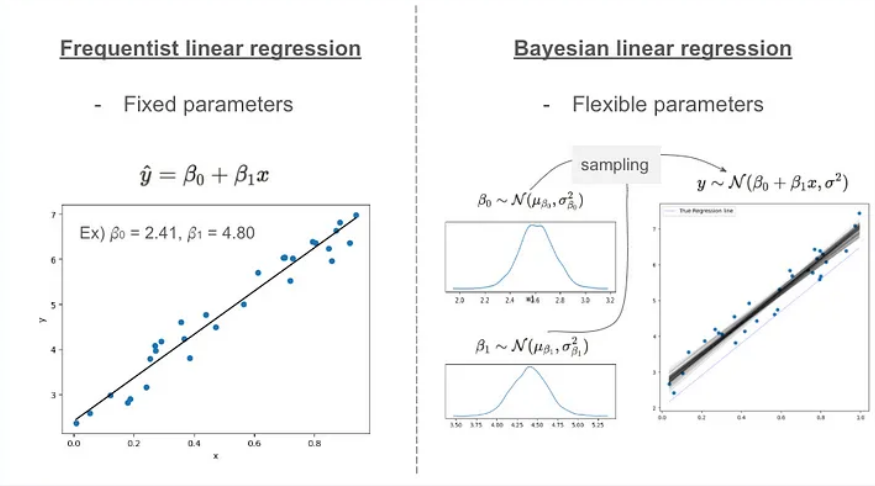

## Teorema de Bayes

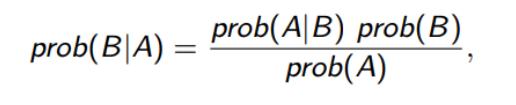
- P(B/A) = distribuição posterior, probabilidade dos parâmetros (A), dado os dados observados
- P(A/B) = probabilidade de ver os dados, dada uma configuração de parâmetros (B)
- P(B) = distribuição à priori, probabilidade dos parâmetros antes de se ver os dados
- P(A) = probabilidade marginal dos dados, serve para normalizar a equação

## Treinamento

- 1: Modela-se a relação entre a variável dependete y e as variáveis independentes x, com um modelo de Regressão Linear Simples, por exemplo
- 2: Os coeficientes a serem estimados vêm de uma distribuição à priori, e assume-se que essa distribuição é normal
- 3: O modelo iterativamente usa o teorema de bayes para calcular a distribuição dos coeficientes, utilizando a informação a priori e a informação dos dados
- 4: No fim, preve-se a variável target integrando sobre a distribuição superior e tomando a média ponderada dos valores dos coeficientes

## Vantagens
- A regularização ajuda a evitar o overfitting
- Adequa-se a problemas lineares e para pequenos conjuntos de dados

## Desvantagens
- Menor interpretabilidade que regressão linear simples
- Não possui desempenho tão adequado para problemas não lineares

In [71]:
evaluate(br_model, test_features, test_labels)

Model Performance:
MAE: 0.0330
MSE: 0.0020
RMSE: 0.0447
R² Score: 0.5255
SMAPE: 4.79%
Accuracy (100 - SMAPE): 95.21%


{'MAE': 0.03303483740331772,
 'MSE': 0.0019948099924382893,
 'RMSE': np.float64(0.044663295808060215),
 'R2': 0.5254925164694308,
 'SMAPE': np.float64(4.79437769970479),
 'Accuracy': np.float64(95.2056223002952)}

# KNeighbors Regressor

- Modelo preditivo que estima as previsões baseado na média dos vizinhos mais próximos

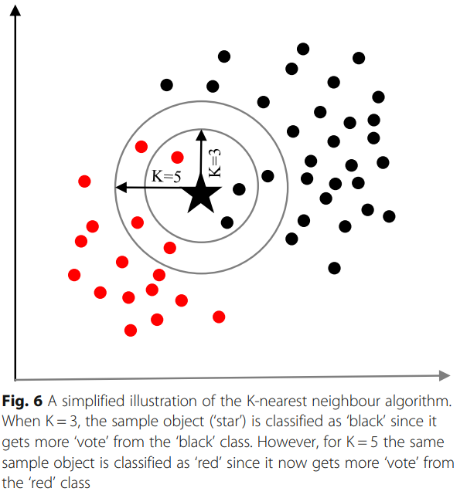

- A imagem demonstra como funciona um KNeighbors Classifier, mas o Regressor funciona de uma forma muito semelhante:
    - 1: Calcula a distância entre o novo ponto e todos os pontos do conjunto de treinamento em um espaço N dimensional (N o número de features)
    - 2: Seleciona os K vizinhos mais próximos
    - 3: Calcula a média dos valores desses K vizinhos
    - 4: Atribui essa média como valor previsto
## Vantagens
 - Interpretabilidade fácil
 - Não assume requisito para relação entre variáveis
 - Pode capturar padrões mais complexos, uma vez que baseia-se em similaridade da vizinhança
## Desvantagens
 - Caro computacionalmente
 - Sensível a escala, pois normalmente é baseado em distâncias. Funciona melhor para dados normalizados
 - Performa pior para alta dimensionalidade (muitas features)

In [72]:
evaluate(knn_model, test_features, test_labels)

Model Performance:
MAE: 0.0312
MSE: 0.0018
RMSE: 0.0426
R² Score: 0.5674
SMAPE: 4.52%
Accuracy (100 - SMAPE): 95.48%


{'MAE': 0.031198090083722367,
 'MSE': 0.001818431457215976,
 'RMSE': np.float64(0.042643070447799324),
 'R2': 0.5674478581883925,
 'SMAPE': np.float64(4.521012085564243),
 'Accuracy': np.float64(95.47898791443576)}

## Random Forest Regressor

- Utiliza um conjunto de árvores de decisão para previsão
- Cria múltiplas Decision Trees a partir de subconjuntos aleatórios usando a técnica de bagging (ensemble)
- Cada árvore gera um resultado e o modelo agrega as previsões 

## Bagging (Bootstrap Agregation)
- Reduz o overfitting combinando vários modelos mais fracos (base learners)
- A partir do conjunto de dados original, cria vários subconjuntos aleatórios (bootstrap)
- Treina-se os modelos de Decision Tree independentemente
- Para regressão, usa-se a média das previsões

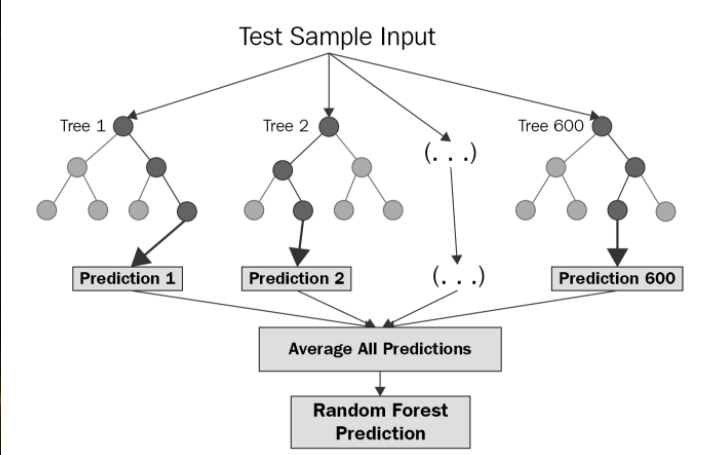
## Vantagens
   - Redução de Overfitting: menos propensas a overfitting, pois as árvores de decisão são treinadas independentemente
   - Lida com relações não lineares
   - Reduz o viés e variância ao comparar múltiplas árvores
   - Funciona bem para grandes volumes de dados e pode tratar valores ausentes
## Desvantagens
   - Custo computacional e modelo complexo

In [73]:
evaluate(rf_model, test_features, test_labels)

Model Performance:
MAE: 0.0287
MSE: 0.0016
RMSE: 0.0398
R² Score: 0.6233
SMAPE: 4.16%
Accuracy (100 - SMAPE): 95.84%


{'MAE': 0.028715576359073715,
 'MSE': 0.0015836376042137903,
 'RMSE': np.float64(0.039794944455468086),
 'R2': 0.6232985110118894,
 'SMAPE': np.float64(4.161299653720885),
 'Accuracy': np.float64(95.83870034627911)}

# Gradient Boosting Regressor

- Usa a ideia de Boosting (ensemble)
- A ideia de Boosting baseia-se em alinhar vários modelos em sequência para que eles aprendam sucessivamente
- A cada iteração, o modelo minimiza a função de perda usando a descida de gradiente, e por isso chamamos de Gradient Boosting

## Treinamento do Modelo

- Começa com modelo base, geralmente uma árvore de decisão
- Calcula-se os erros a partir das previsões, baseando-se na ideia da diferença entre os valores reais e os previstos
- Antes de aplicar o próximo modelo, o algoritmo aplica o método de descida de gradiente para alterar os pesos
- Treina um modelo novo
- Após treinar um novo modelo, esse algoritmo calcula os novos resíduos subtraindo as previsões atualizadas dos reais valores de y.  Esses resíduos representam a variedad inexplicada na variável alvo
- O processo repete-se, até que combina-se todos os modelos, considerando a estimativa refinada das previsões finais de y.

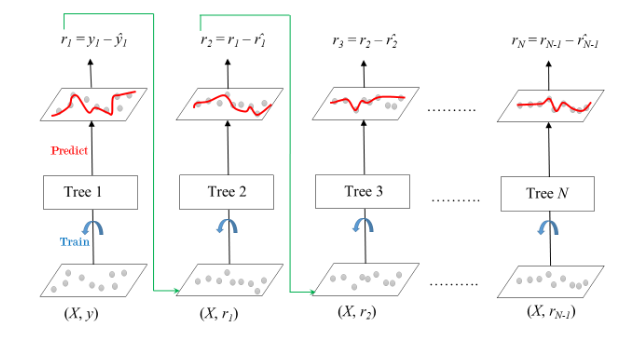

## Vantagens
- Reduz Overfitting por combinar sequencialmente várias árvores de decisão
- Flexibilidade de ajuste de hiperparâmetros
- Alto desempenho em previsões

## Desvantagens
- Difícil interpretabilidade
- Treinamento lento e custo computacional
- Embora flexível a hiperparâmetros, sensível a eles

In [74]:
evaluate(gb_model, test_features, test_labels)

Model Performance:
MAE: 0.0286
MSE: 0.0016
RMSE: 0.0395
R² Score: 0.6292
SMAPE: 4.14%
Accuracy (100 - SMAPE): 95.86%


{'MAE': 0.02858175532440124,
 'MSE': 0.0015588361286089502,
 'RMSE': np.float64(0.039482098837434546),
 'R2': 0.6291980632608296,
 'SMAPE': np.float64(4.14322930264489),
 'Accuracy': np.float64(95.8567706973551)}

# SVR (Support Vector Regressor)

- Visa encontrar uma função que preveja uma variável target contínua, maximizando a margem entre os valores previstos e os valores reais.
- Margem: O SVR percebe uma margem ao redor da linha de previsão e o objetivp é ajustar a linha dentro dessa margem
- Os vetores suporte são os vetores mais próximos da linha de regressão e que definem a margem
- É possível uma modelagem não linear
- O SVR é robusto a outliers, pois baseia-se nos valores próximos à margem

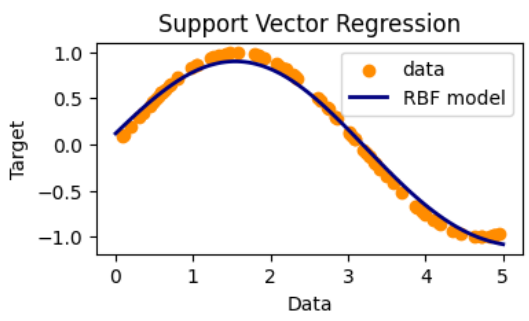

## Vantagens
- Performa bem para alta dimensionalidade
- Pode modelar relações não lineares
- Robusto a overffiting e a outliers

## Desvantagens
- Sensível a escolha de parâmetros
- Custo computacional
- Difícil interpretabilidade

In [75]:
evaluate(svr_model, test_features, test_labels)

Model Performance:
MAE: 0.0345
MSE: 0.0020
RMSE: 0.0452
R² Score: 0.5136
SMAPE: 5.00%
Accuracy (100 - SMAPE): 95.00%


{'MAE': 0.03450727948232117,
 'MSE': 0.002044636950036445,
 'RMSE': np.float64(0.045217661925805556),
 'R2': 0.5136401273438953,
 'SMAPE': np.float64(4.999499641577319),
 'Accuracy': np.float64(95.00050035842268)}

# Prevendo novo dado

In [76]:
new_data = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}


# Processos de Transformação do dado novo

- A função aplica o pré-processamento necessário ao novo conjunto de dados, incluindo:
- Substituição de valores da coluna 'bairro' utilizando um encoder salvo.
- One-Hot Encoding nas colunas 'bairro_group' e 'room_type'.
- Extração de informações de data a partir da coluna 'ultima_review'.
- Aplicação da transformação 'yeo-johnson' em colunas específicas usando modelos previamente treinados.
- Aplicação do MinMaxScaler em todas as colunas numéricas, usando os scalers previamente salvos.
- Ajuste do número de colunas no novo conjunto de dados para garantir que seja compatível com o modelo original.
- A coluna 'price' é descartada, pois não deve ser usada para previsão.

In [81]:

"""
    Aplica o mesmo pré-processamento aos novos dados que foi feito durante o treinamento do modelo.

    Parâmetros
    ----------
    data= O DataFrame original usado para treinar o modelo.
    new_data_function = O novo conjunto de dados a ser pré-processado.
    bairro_encoder = O dicionário de mapeamento para a codificação da coluna 'bairro'.
    model_prefix = Prefixo do nome do arquivo do modelo de transformação (por exemplo, "power_transformer_model").
    
    Retorno
    O conjunto de dados pré-processado pronto para ser usado em previsões, com as mesmas transformações aplicadas no modelo treinado.
    
"""
def transformation_new_data(data, new_data_function, bairro_encoder, model_prefix="power_transformer_model"):
    ## Aplicar o mesmo pré-processamento de dados (mesmo que foi feito durante o treinamento)
    ## Substituir os valores de 'bairro' usando o encoder salvo
    new_data_cleaned = new_data_function.copy()
    new_data_cleaned['bairro'] = new_data_cleaned['bairro'].map(bairro_encoder)
    new_data_cleaned['bairro'] = new_data_cleaned['bairro'].fillna(222)
    ## One-hot Encoding
    new_data_cleaned = pd.get_dummies(new_data_cleaned, columns=['bairro_group'], dtype=int)
    new_data_cleaned = pd.get_dummies(new_data_cleaned, columns=['room_type'], dtype=int)
    ## Criar as novas colunas de data a partir de 'ultima_review'
    new_data_cleaned['ultima_review'] = pd.to_datetime(new_data_cleaned['ultima_review'])
    new_data_cleaned['ano'] = new_data_cleaned['ultima_review'].dt.year
    new_data_cleaned['mes'] = new_data_cleaned['ultima_review'].dt.month
    new_data_cleaned['dia'] = new_data_cleaned['ultima_review'].dt.day
    new_data_cleaned['dia_da_semana'] = new_data_cleaned['ultima_review'].dt.weekday  # 0=segunda-feira, 6=domingo
    new_data_cleaned = new_data_cleaned.drop(columns = ['id', 'host_id', 'host_name', 'nome', 'ultima_review'])
    
    ## Aplicando a transformação 'yeo-johnson' para as colunas, com os modelos salvos
    columns_to_transform = ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                            'calculado_host_listings_count']
    
    for col in columns_to_transform:
        model_filename = f"modelos_transfomacao_dados/{model_prefix}_{col}.pkl"
        pt = joblib.load(model_filename)  # Carregar o modelo de transformação
        new_data_cleaned[col] = pt.transform(new_data_cleaned[[col]])  # Aplicar a transformação

    ## Carregando o modelo de MinMaxScaler
    scalers = joblib.load('modelos_transfomacao_dados/scalers_model.pkl')  # Carregar o modelo de escalonamento
    # Aplicando o MinMaxScaler nas colunas numéricas
    for col in new_data_cleaned.columns:
        scaler = scalers[col]  # Obter o scaler para a coluna
        new_data_cleaned[col] = scaler.transform(new_data_cleaned[[col]])  # Aplicar o MinMaxScaler
    columns_in_df2_not_in_df1 = set(data.columns) - set(new_data_cleaned.columns)

    for col in columns_in_df2_not_in_df1:
        new_data_cleaned[col] = 0 
    new_data_cleaned= new_data_cleaned[data.columns]
    new_data_cleaned = new_data_cleaned.drop(columns = ['price'])
    
    return new_data_cleaned


In [82]:
class_dict = dict(zip(encoder.classes_, range(len(encoder.classes_))))
class_dict_inv = {v: k for k, v in class_dict.items()}


In [84]:
# new_data = pd.DataFrame([new_data])


In [85]:
new_data_transformed = transformation_new_data(data_ml, new_data, class_dict_inv)

C:\Users\gabia\AppData\Local\Temp\ipykernel_7892\2298907322.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_data_cleaned['bairro'] = new_data_cleaned['bairro'].fillna(222)


In [86]:
data_ml.head()

bairro  latitude  longitude     price  minimo_noites  numero_de_reviews  \
0  0.577273  0.614199   0.490469  0.758996       0.000000           0.694769   
1  0.427273  0.748252   0.569257  0.723153       0.425715           0.000000   
2  0.186364  0.448496   0.535649  0.673462       0.000000           0.913143   
3  0.277273  0.722820   0.565324  0.662806       0.746063           0.460006   
4  0.622727  0.599802   0.506972  0.748824       0.425715           0.760283   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
0         0.249178                       0.518064             0.972603   
1         0.387686                       0.000000             1.000000   
2         0.805027                       0.000000             0.531507   
3         0.075155                       0.000000             0.000000   
4         0.341345                       0.000000             0.353425   

   bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0                 0.0                    0.0                     1.0   
1                 0.0                    0.0                     1.0   
2                 0.0                    1.0                     0.0   
3                 0.0                    0.0                     1.0   
4                 0.0                    0.0                     1.0   

   bairro_group_Queens  bairro_group_Staten Island  room_type_Entire home/apt  \
0                  0.0                         0.0                        1.0   
1                  0.0                         0.0                        0.0   
2                  0.0                         0.0                        1.0   
3                  0.0                         0.0                        1.0   
4                  0.0                         0.0                        1.0   

   room_type_Private room  room_type_Shared room    ano       mes       dia  \
0                     0.0                    0.0  1.000  0.363636  0.666667   
1                     1.0                    0.0  1.000  0.454545  0.533333   
2                     0.0                    0.0  1.000  0.545455  0.133333   
3                     0.0                    0.0  0.875  0.909091  0.600000   
4                     0.0                    0.0  1.000  0.454545  0.700000   

   dia_da_semana  
0       0.166667  
1       0.500000  
2       0.666667  
3       0.000000  
4       0.833333

In [87]:
new_data_transformed

bairro  latitude  longitude  minimo_noites  numero_de_reviews  \
0  1.009091  0.614199   0.490469            0.0           0.694769   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
0         0.249178                       0.518064             0.972603   

   bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0                   0                      0                     1.0   

   bairro_group_Queens  bairro_group_Staten Island  room_type_Entire home/apt  \
0                    0                           0                        1.0   

   room_type_Private room  room_type_Shared room  ano       mes       dia  \
0                       0                      0  1.0  0.363636  0.666667   

   dia_da_semana  
0       0.166667

In [88]:
input_data = new_data_transformed.values

In [89]:
"""
    Desfaz as transformações aplicadas ao preço previsto, utilizando o MinMaxScaler e PowerTransformer salvos.

    Parâmetros
    input_data = valores a serem previstos (já tratados)
    model = modelo a fazer a previsão
    
    Retorno
    O valor do preço destransformado, após a aplicação do MinMaxScaler e PowerTransformer.
"""
def inverse_transform_prediction(input_data, model):
    predicted_price = model.predict(input_data)

    ## Carregar os escaladores e o PowerTransformer salvos em arquivos
    scalers = joblib.load('modelos_transfomacao_dados/scalers_model.pkl')
    power_transformer = joblib.load('modelos_transfomacao_dados/power_transformer_model_price.pkl')

    ## Garantir que predicted_price seja um array numpy e esteja em formato 2D (necessário para o inverse_transform)
    predicted_price = np.array(predicted_price).reshape(-1, 1)  # Transformar para 2D
    
    ## Destransformando o dado utilizando o escalador de índice 'price' do MinMaxScaler
    ## A transformação é linear, o processo inverso retorna um resultado exato
    dados_destransformados_minmax = scalers['price'].inverse_transform(predicted_price)
    ## Destransformando o dado utilizando o PowerTransformer
    ## A transformação é não linear, o processo inverso retorna um resultado muito próximo de quando foi transformado, mas não exato
    dados_destransformados_power = power_transformer.inverse_transform(dados_destransformados_minmax)

    return dados_destransformados_power



In [94]:
# Supondo que você já tenha treinado os modelos e tenha as variáveis correspondentes.
models_dict = {
    'Linear Regression': lr_model,
    'Bayesian Ridge': br_model,
    'K-Nearest Neighbors': knn_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Regressor': svr_model
}

results = []
# Loop sobre o dicionário de modelos
for model_name, model in models_dict.items():
    # Chame a função de inversão da transformação nas previsões
    result = inverse_transform_prediction(input_data, model)
    results.append(result)
    # Exiba o resultado de forma bonita
    print(f"Modelo: {model_name} - Preço do Imóvel: {result}")


Modelo: Linear Regression - Preço do Imóvel: [[275.51007764]]
Modelo: Bayesian Ridge - Preço do Imóvel: [[275.34814002]]
Modelo: K-Nearest Neighbors - Preço do Imóvel: [[230.87965906]]
Modelo: Random Forest - Preço do Imóvel: [[269.56176944]]
Modelo: Gradient Boosting - Preço do Imóvel: [[273.70353766]]
Modelo: Support Vector Regressor - Preço do Imóvel: [[367.8818069]]


C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
C:\Users\gabia\Downloads\anaconda\envs\meu_ambiente\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarn

In [102]:
sorted_results = sorted(results)
filtered_results = sorted_results[1:-1]
mean_result = sum(filtered_results) / len(filtered_results)

print(f"Média dos resultados(retirando-se o menor e maior valor): R${mean_result}")


Média dos resultados(retirando-se o menor e maior valor): R$[[273.53088119]]


## Verificação Geral se o Preço é coerente

In [91]:
manhattan_entire_home = data[(data['bairro_group'] == 'Manhattan') & (data['room_type'] == 'Entire home/apt')]

media_preco = manhattan_entire_home['price'].mean()

print(f"A média de preços para 'Entire home/apt' em Manhattan é: ${media_preco:.2f}")

A média de preços para 'Entire home/apt' em Manhattan é: $249.24
